In [5]:
import music21 as m21
from music21 import * 
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from collections import Counter


In [6]:
#リズムなどメタデータの取得をGracenoteAPIに任せる
import pygn
import requests
import xml


In [7]:
#ピッチナンバーと調の変換
map_pitch_class = {"C":0,"C#":1,"D":2,"D#":3,"E":4,"F":5,"F#":6,"G":7,"G#":8,"A":9,"B-":10,"B":11}
#覚えているかどうか
memorable = {"あまり覚えてない":1,"だいたいは覚えている":2,"完璧に覚えている":3}
#

In [8]:
def shuukei(vocalpart):
    """
    音価・音高のペアのオブジェクトを楽譜から作る
    タイの部分→連結

    """
    record = []
    checker = False
    #タイがついた場合の途中記録用
    pitch_tmp = 0.0
    duration_tmp = 0.0
    for i in vocalpart.flat.notesAndRests.stream():
        
        #タイがついている
        if i.tie:
            #タイのはじめの音ならまず音高を記録する
            if checker == False:
                if i.isNote == True:
                    #record.append([i.pitch.ps,i.duration.quarterLength])
                    #音符はノート番号
                    pitch_tmp = i.pitch.ps
                    duration_tmp += i.duration.quarterLength
                elif i.isRest == True:
                    #record.append(["rest",i.duration.quarterLength])
                    #休符は無限にする
                    pitch_tmp = np.inf
                    duration_tmp += i.duration.quarterLength
                
            #タイの途中の音なら音長を足していく      
            else:
                duration_tmp += i.duration.quarterLength
            
            #タイはついている   
            checker = True
        
        #タイがついてない    
        else:
            checker = False
            #直前がタイの最後の音ならタイでつながって一音になった音を追加
            if not duration_tmp == 0.0:
                record.append([pitch_tmp,duration_tmp])
                duration_tmp = 0.0
            
            #そうでなければ普通に追加
            if i.isNote == True:
                record.append([i.pitch.ps,i.duration.quarterLength])
            elif i.isRest == True:
                record.append([np.inf,i.duration.quarterLength])

    return record

In [9]:
def count_duration(song):
    #[音高,音価]が要素になったリストから音価を集計する
    lis = []
    for n in range(len(song)):
        lis.append(song[n][1])
    duration_count = Counter(lis)
    #集計結果のカウンターを返す
    #sorted_count = sorted(duration_count.items(),key=lambda x:x[0])
    #return sorted_count
    
    return duration_count

In [10]:
def count_pitch(song):
    #[音高,音価]が要素になったリストから音高を集計する
    lis = []
    for n in range(len(song)):
        lis.append(song[n][0])
    pitch_count = Counter(lis)
    #集計結果のカウンターを返す
    return pitch_count

In [11]:
def make_pitch_bigram(shuukei_obj):
    #[音高,音価]が要素になったリストから音高のBigramのリストを作成する
    pitch_diff = []
    for i in range(len(shuukei_obj)-1):
        if shuukei_obj[i+1][0] > 10000 and shuukei_obj[i][0] > 10000:
        	pass
        else:
            pitch_diff.append(shuukei_obj[i+1][0] - shuukei_obj[i][0])
    return pitch_diff

In [12]:
def make_duration_bigram(shuukei_obj):
    #[音高,音価]が要素になったリストから音価のBigramのリストを作成する
    duration_diff = []
    for i in range(len(shuukei_obj)-1):
        duration_diff.append(shuukei_obj[i+1][1] - shuukei_obj[i][1])
    return duration_diff

In [13]:
def jump_rate(bigram_status):
    #バイグラム列から跳躍、下降跳躍、上向跳躍の割合を返す
    up_jump = 0
    down_jump = 0
    slope = 0 
    for key in bigram_status.keys():
        if np.abs(key) <= 2:
            slope += bigram_status[key]
        elif np.abs(key) <= 10000:
            if key > 0:
            	up_jump += bigram_status[key]
            else:
                down_jump += bigram_status[key]
    all_of_notes = up_jump + down_jump + slope
    
    return [(up_jump+down_jump)/all_of_notes,up_jump/all_of_notes,down_jump/all_of_notes]         

In [14]:
def delete_inf(bigram_status): 
    #休符を含むBigramから休符を削除
    del bigram_status[np.inf]
    del bigram_status[-np.inf]
    del bigram_status[None]
    return bigram_status

In [15]:
#Aメロ,Bメロ,サビに分割
#各セクションの始点と終点の小節番号を引数に与える
def separate_section(piece,a_start,a_end,b_start,b_end,s_start,s_end):
    sections = []
    amero = piece.measures(a_start,a_end)
    bmero = piece.measures(b_start,b_end)
    sabi = piece.measures(s_start,s_end)
        
    print(sabi)
    sections.append(amero)
    sections.append(bmero)
    sections.append(sabi)
    
    return sections

In [16]:
#カウンターオブジェクトのプロット
def counter_plot(counter,song,section,analysee_name,bar_color):
    left = counter.keys()
    height = counter.values()
    plt.title("song: {} ({}'s {})".format(song,section,analysee_name))
    plt.bar(left,height,color=bar_color)
    for x, y in zip(left, height):
        try: 
            plt.text(x, y, y, ha='center', va='bottom')
        except ValueError: 
            pass 
    plt.grid()
    plt.show()

In [17]:
#音高、音価のペアのリストをセクションごとに作成
def make_note(sections):
    notes = []
    for item in sections:
        note_obj = shuukei(item) 
        notes.append(note_obj)
    return notes

In [18]:
#セクションごとに音高、音価のペア列から音程列を作成
def make_pitch_diff(notes):
    ontei = []
    for item in notes:
        bigram = make_pitch_bigram(item)
        onteiobj = delete_inf(Counter(bigram))
        ontei.append(onteiobj)
    return ontei

In [26]:
#音域の計算
def pitch_range(sec):
    a = []
    for i in sec.flat.notes:
        a.append(i.pitch.ps)
    max_note = int(max(a))
    min_note = int(min(a))
    return [max_note,min_note,max_note-min_note]

In [31]:
def notenum2pitch(num):
    convert = {0:"C",1:"C#",2:"D",3:"D#",4:"E",5:"F",6:"F#",7:"G",8:"G#",9:"A",10:"B-",11:"B"}
    octave = int(num/12)-1
    return convert[num%12]+ str(octave)

In [35]:
notenum2pitch(63)

'D#4'

## 予備実験概要

実験参加者数　6人（21～24歳の男子６人、内音楽経験あり３人）
実施楽曲　6曲＋α


In [36]:
analysis_corpus = []
analysis_section = {0:"A melody",1:"B melody",2:"Sabi"}

## テストコード

#楽譜の読み込み
cherry = m21.converter.parse("./cherry.xml").parts[0]
#各セクションに分ける
cherry_section = []
cherry_a = cherry.measures(1,8)
cherry_b = cherry.measures(9,16)
cherry_s = cherry.measures(16,24)

cherry_section.append(cherry_a)
cherry_section.append(cherry_b)
cherry_section.append(cherry_s)
#音高,音価の列のオブジェクトを作成
cherry_section_notes = []
for item in cherry_section:
    notes = shuukei(item)
    cherry_section_notes.append(notes)
#音高Bigramを作成
cherry_ontei = []
for item in cherry_section_notes:
    bigram = make_pitch_bigram(item)
    onteiobj = delete_inf(Counter(bigram))
    cherry_ontei.append(onteiobj)
#音高差の集計をプロット
for num,item in enumerate(cherry_ontei):
    counter_plot(item,"cherry",str(analysis_section[num]),"pitch_diff")
#音高の集計
for item in cherry_section:
    item.plot("histogram","pitch")
    item.plot("histogram","pitchclass") 

for num,item in enumerate(cherry_section_notes):
    dcount = count_duration(item)
    #print(dcount)
    duras = {}
    for i in sorted(dcount.keys()):
        new_key = str(i)
        duras[new_key] = dcount[i]
    counter_plot(duras,"cherry",str(analysis_section[num]),"duration by Quarter Length")
#調,音符数,跳躍率
analysis_section = {0:"Amelody",1:"Bmelody",2:"Sabi"}
print(len(cherry))
print(analysis.discrete.analyzeStream(cherry,"Krumhansl"))
for num,section in enumerate(cherry_section):
    print(section)
    print("-------{}の統計情報---------".format(analysis_section[num]))
    print("調:{}".format(analysis.discrete.analyzeStream(section,"Krumhansl")))

In [37]:
class gakuhu_object:
    """
    ボーカルパートのあらゆる情報を保持するクラス
    
    __init__(self,file)　
    初期化、読み込む楽譜ファイルを与える
    
    separate_section(self,a_start,a_end,b_start,b_end,s_start,s_end) 
    A,B,サビに楽譜を分割、それぞれのセクションの始めの小節と終わりの小節の番号を与える
    """
    
    #コンストラクタ
    def __init__(self,name,file,separate_info):
        #楽曲名
        self.name = name
        #ボーカルパートを読み込み（一つ目のパートがボーカルである前提・・・）
        self.piece = m21.converter.parse("./" + file).parts[0]
        #Aメロ、Bメロ、サビのオブジェクトを保持する
        self.sections = separate_section(self.piece,separate_info[0],separate_info[1],separate_info[2],separate_info[3],separate_info[4],separate_info[5])
        #音高、音列のペア
        self.notes = make_note(self.sections)
        #音程列
        self.ontei = make_pitch_diff(self.notes)
        
        analysis_corpus.append(self)
        
    #調の表示
    def show_key(self):
        print("------------"+self.name +"-------------")
        for num,section in enumerate(self.sections):
            print("-------{}の統計情報---------".format(analysis_section[num]))
            print("調:{}".format(analysis.discrete.analyzeStream(section,"Krumhansl")))
    """
    #音高、音価のペアのリストをセクションごとに作成
    def make_note(self):
        for item in self.sections:
            note_obj = shuukei(item) 
            self.notes.append(note_obj)
    
    #音程列の作成
    def make_pitch_diff(self):
        for item in self.notes:
            bigram = make_pitch_bigram(item)
            onteiobj = delete_inf(Counter(bigram))
            self.notes.append(onteiobj)
    """    
    #音高のカウント
    def counting_pitch(self):
        for num,item in enumerate(self.sections):
            pitch_space = graph.plot.HistogramPitchSpace(item,xHideUnused=False,title=self.name + " " + analysis_section[num] + " pitch")
            pitch_space.colors = "magenta"
            pitch_space.run()
            pitch_class = graph.plot.HistogramPitchClass(item,xHideUnused=False,title=self.name + " " +  analysis_section[num] + " pitch class")
            pitch_class.colors = "cyan"
            pitch_class.run()
            #item.plot("histogram","pitch",xHideUnused=False)
            #item.plot("histogram","pitchclass",xHideUnused=False) 
        
    #音価のカウント
    def counting_duration(self):
        for num,item in enumerate(self.notes):
            dcount = count_duration(item)
            #print(dcount)
            duras = {}
            for i in sorted(dcount.keys()):
                new_key = str(i)
                duras[new_key] = dcount[i]
            counter_plot(duras,self.name,str(analysis_section[num]),"duration by Quarter Length","g")
            
    #音高差の集計をプロット
    def plot_pitch_diff(self):
        for num,item in enumerate(self.ontei):
            counter_plot(item,self.name,str(analysis_section[num]),"pitch_diff","r")
        
    #跳躍進行の割合を表示        
    def calucurate_jump(self):
        for num,sect in enumerate(self.ontei):
            a = delete_inf(Counter(sect))
            jump_status = jump_rate(a)
            print("{}の跳躍情報　跳躍の割合:{:.2},上向跳躍の割合:{:.2},下降跳躍の割合:{:.2}".format(analysis_section[num],jump_status[0],jump_status[1],jump_status[2]))

    #音域（何半音ぶんか）を表示
    def caluculate_pitch_range(self):
        status = []
        for num,sect in enumerate(self.sections):
            status = pitch_range(sect)
            print("{}の音域情報　最高音:{},最低音:{},音域:{}半音".format(analysis_section[num],notenum2pitch(status[0]),notenum2pitch(status[1]),status[2]))
            
        

## 実際に6曲分、分析してみる



In [ ]:
analysis_corpus = []
cherry = gakuhu_object("Cherry","cherry.xml",[1,8,9,15,16,24])
tsunami = gakuhu_object("TSUNAMI","TSUNAMI.xml",[1,16,17,25,25,42])
roman = gakuhu_object("Roman Hikou","roman.xml",[1,8,9,16,16,29])
aporo = gakuhu_object("Aporo","aporo3.xml",[20,34,35,43,44,59])
guren = gakuhu_object("Guren No Yumiya","guren.mxl",[12,27,28,35,36,51])
konayuki = gakuhu_object("Konayuki","konayuki.mxl",[5,26,27,37,37,45])


<music21.stream.Part トラック 0>
<music21.stream.Part ピアノ>
<music21.stream.PartStaff P1-Staff1>
<music21.stream.Part ボーカル>
<music21.stream.Part ボーカル>
<music21.stream.Part Lead>


------------Cherry-------------
-------A melodyの統計情報---------
調:d minor
-------B melodyの統計情報---------
調:a minor
-------Sabiの統計情報---------
調:C major


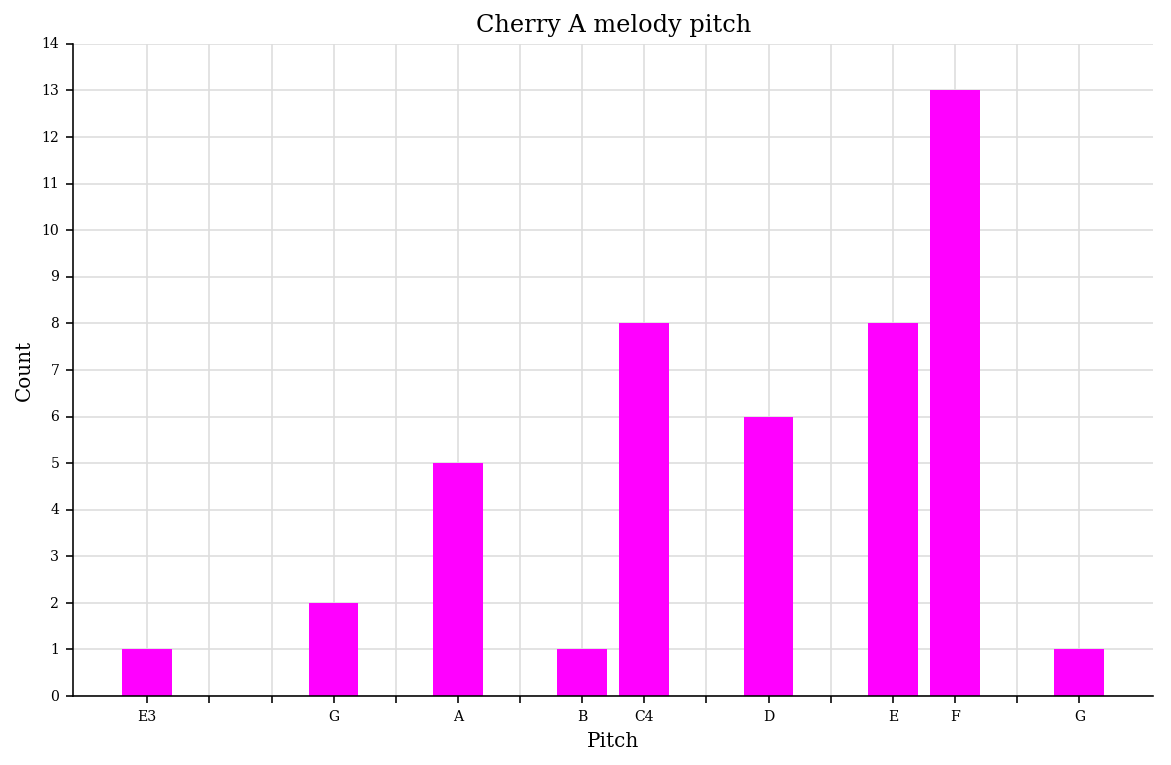

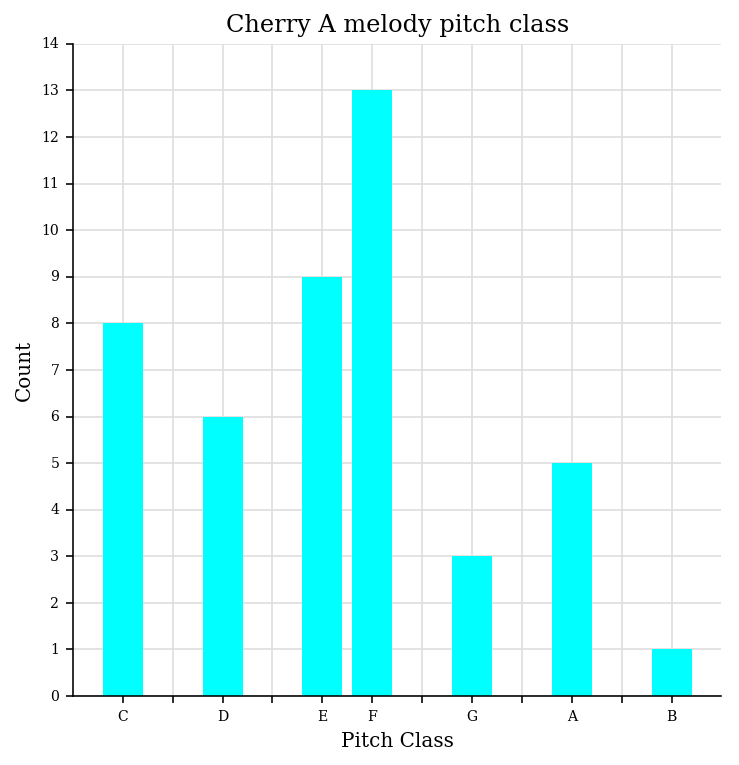

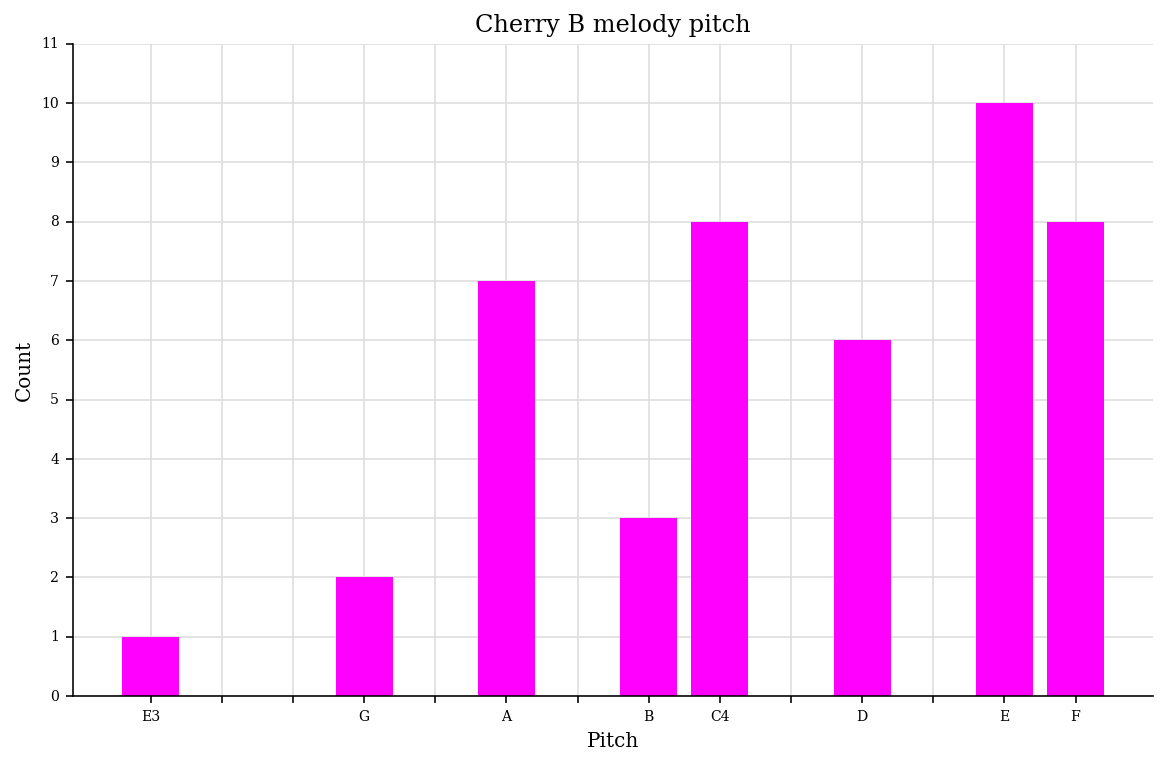

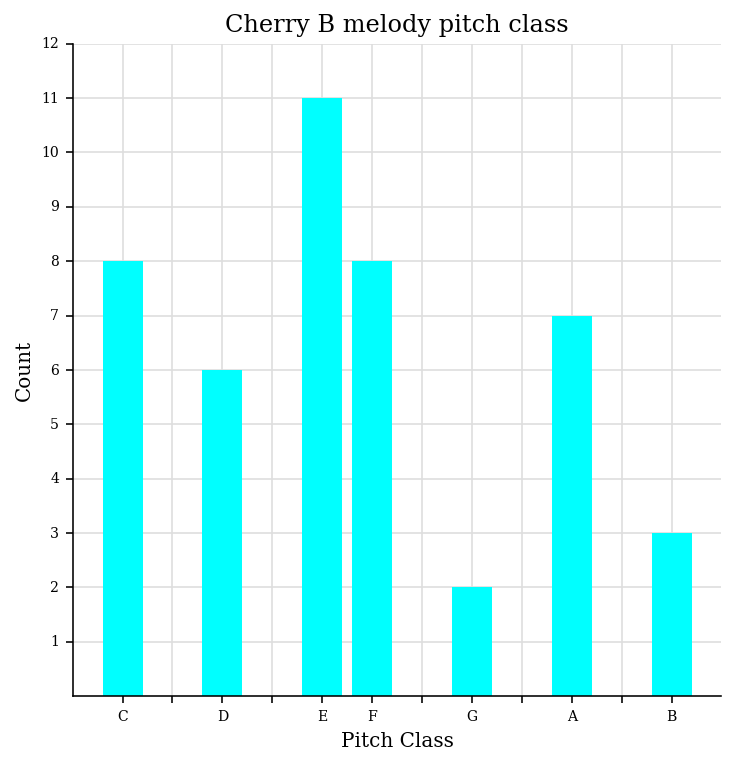

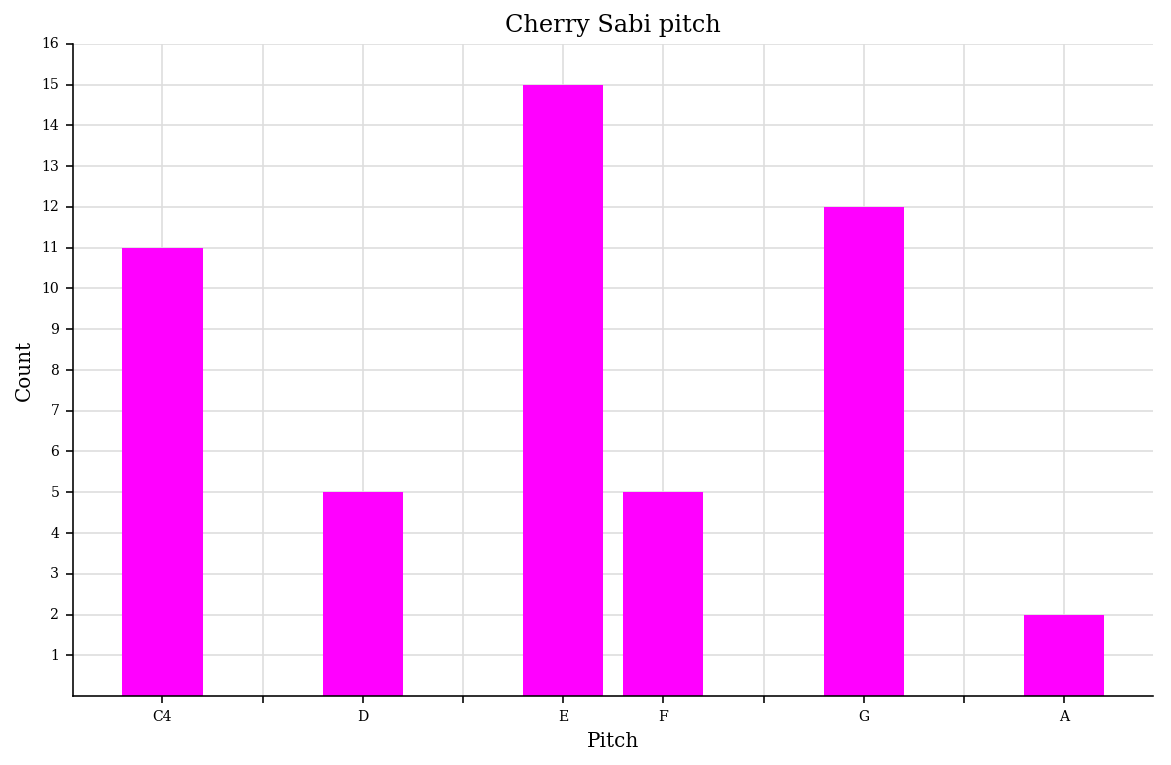

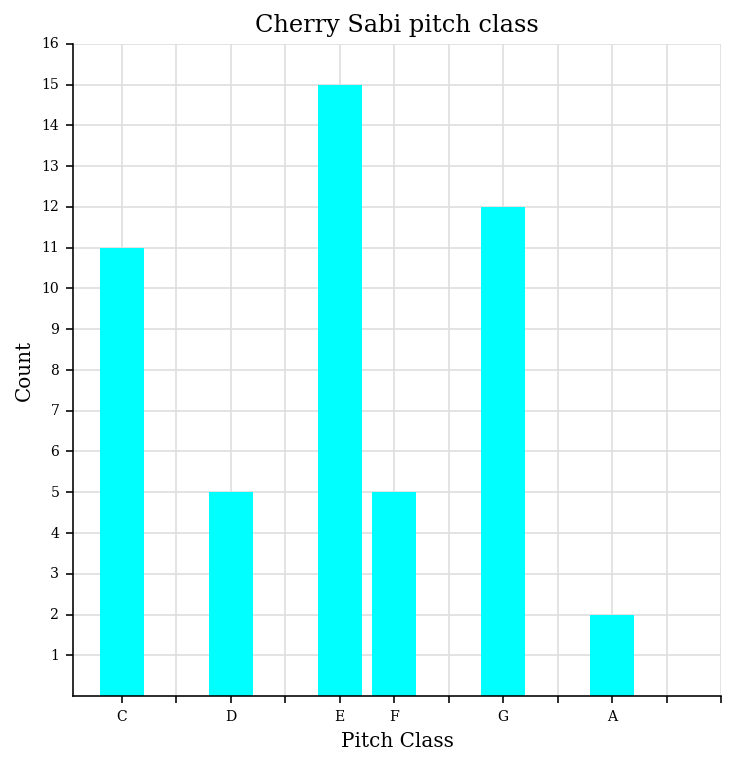

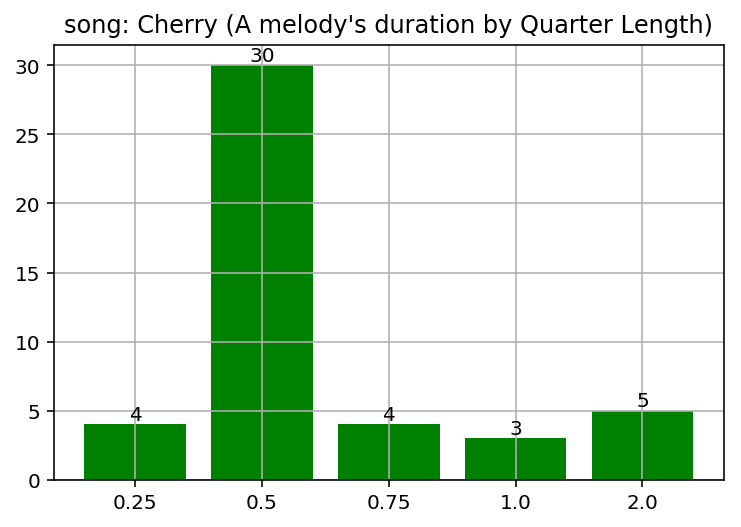

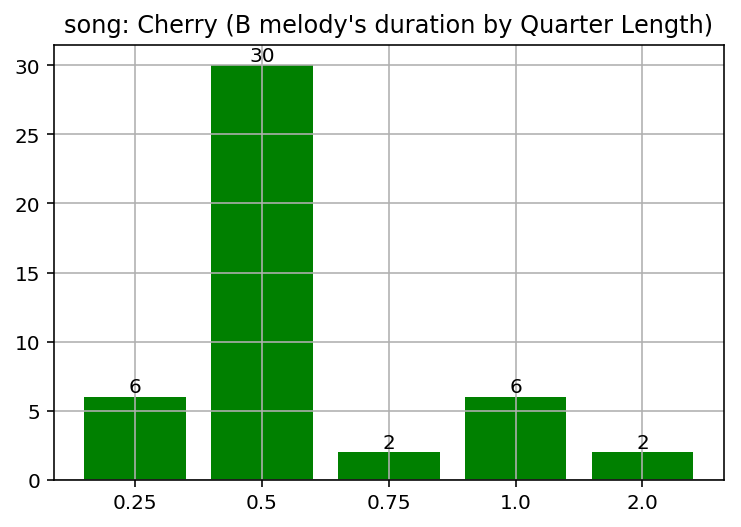

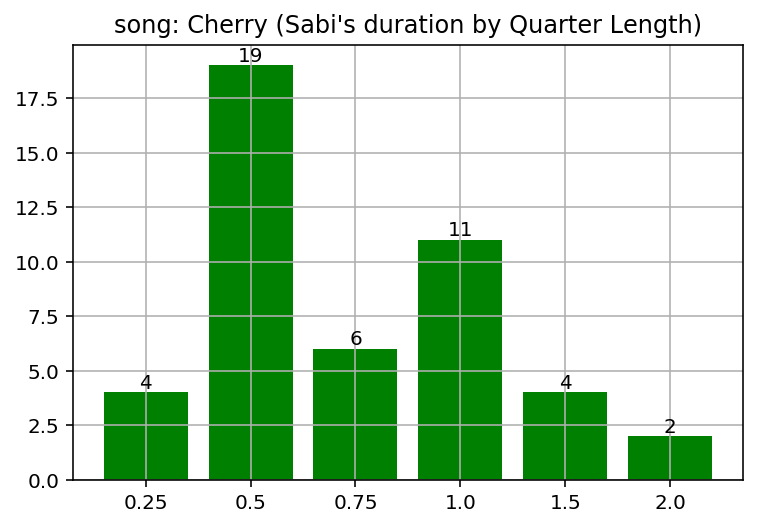

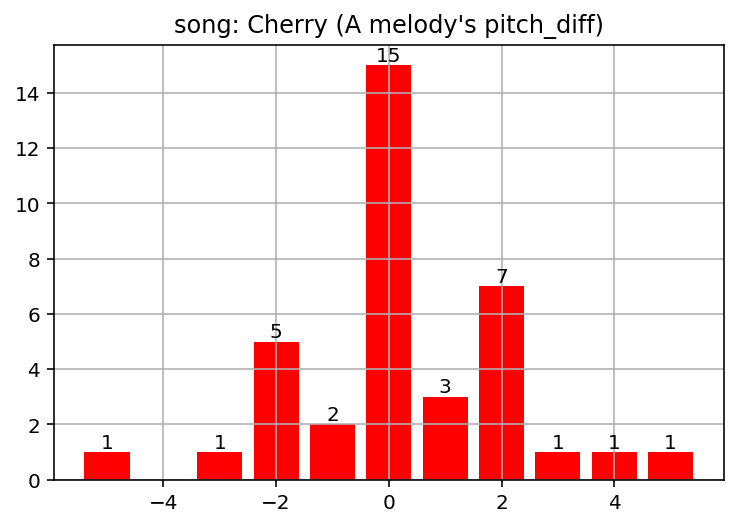

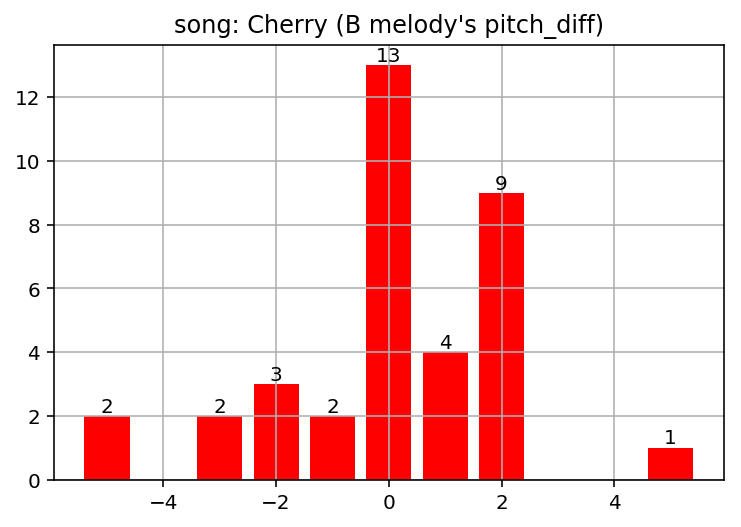

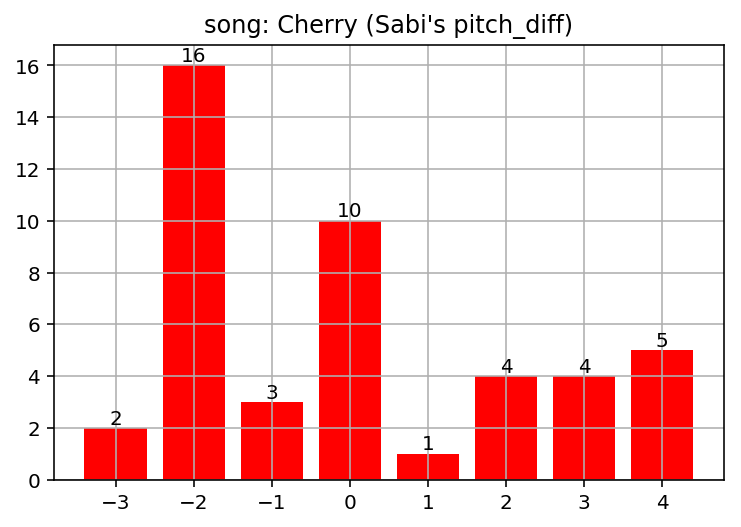

A melodyの跳躍情報　跳躍の割合:0.14,上向跳躍の割合:0.081,下降跳躍の割合:0.054
B melodyの跳躍情報　跳躍の割合:0.14,上向跳躍の割合:0.028,下降跳躍の割合:0.11
Sabiの跳躍情報　跳躍の割合:0.24,上向跳躍の割合:0.2,下降跳躍の割合:0.044
A melodyの音域情報　最高音:G4,最低音:E3,音域:15半音
B melodyの音域情報　最高音:F4,最低音:E3,音域:13半音
Sabiの音域情報　最高音:A4,最低音:C4,音域:9半音
------------TSUNAMI-------------
-------A melodyの統計情報---------
調:D major
-------B melodyの統計情報---------
調:D major
-------Sabiの統計情報---------
調:D major


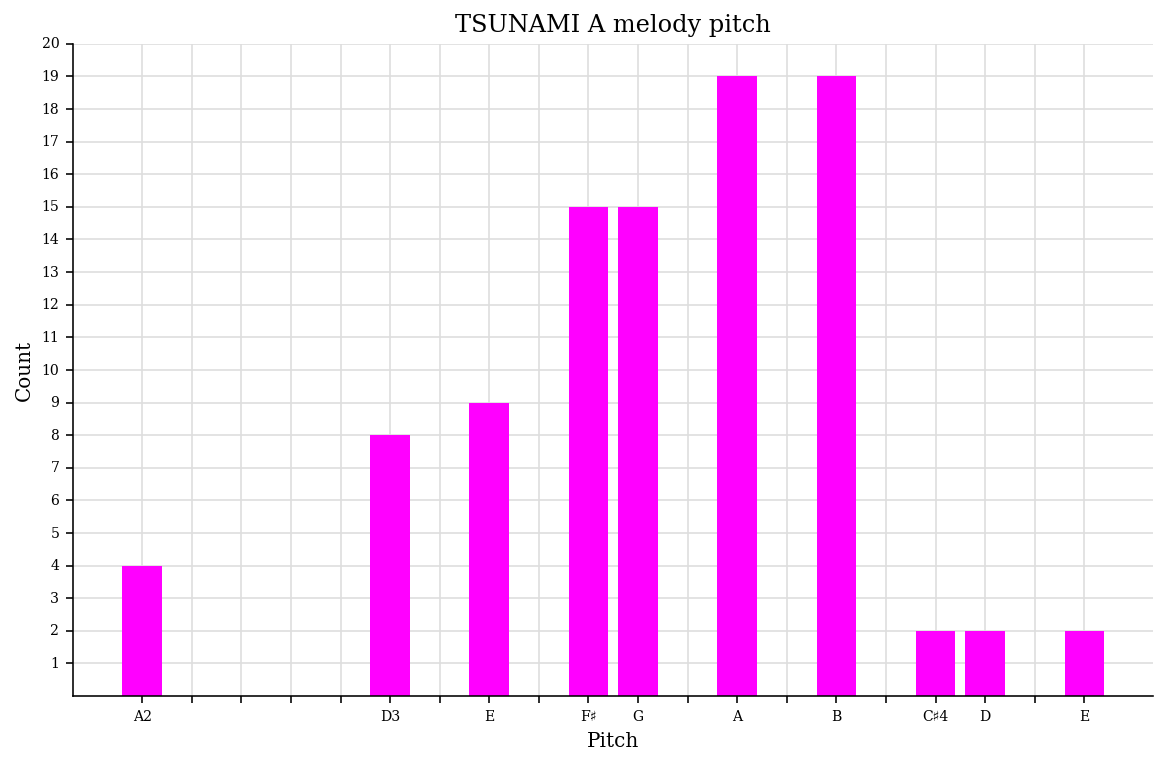

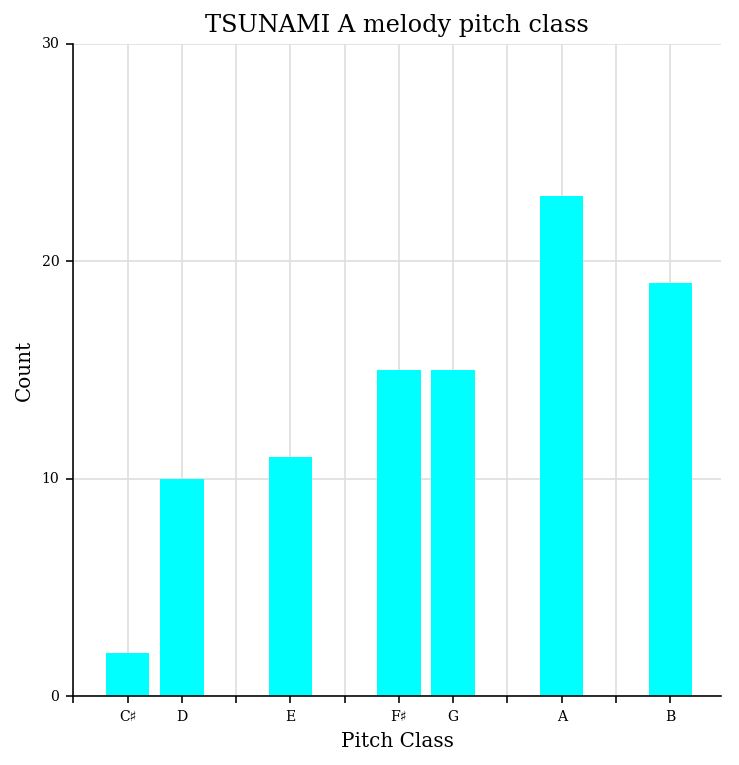

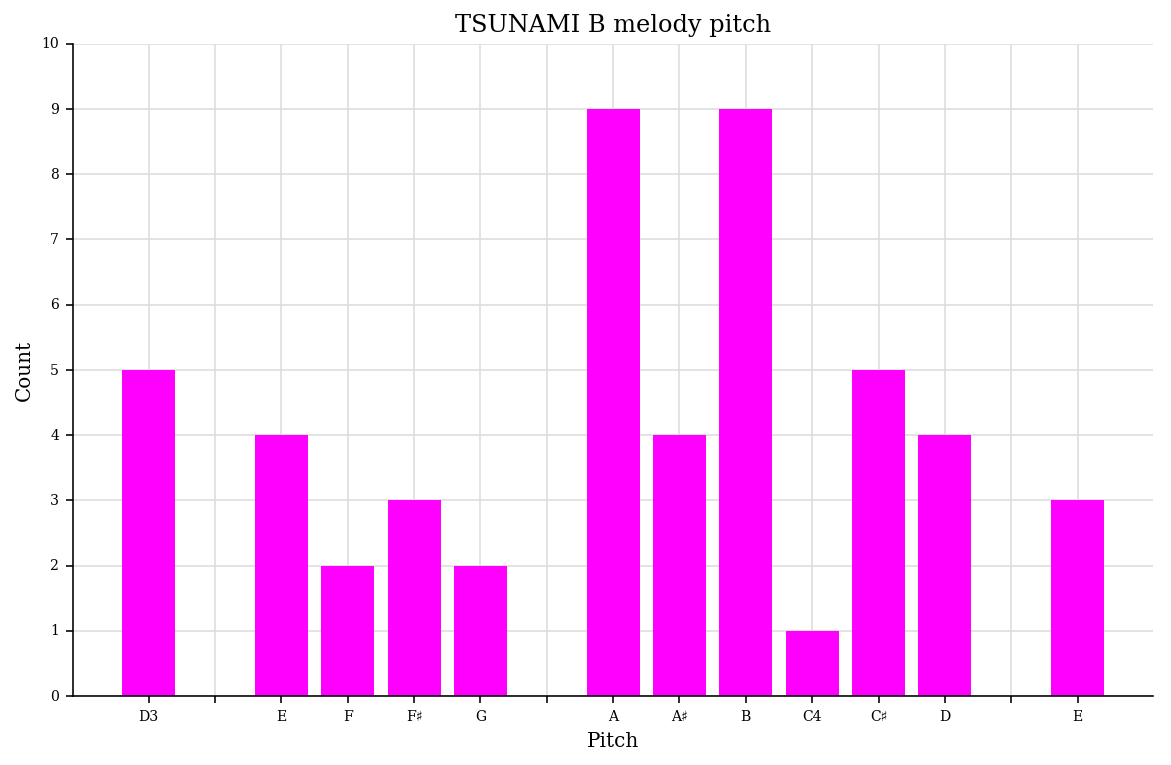

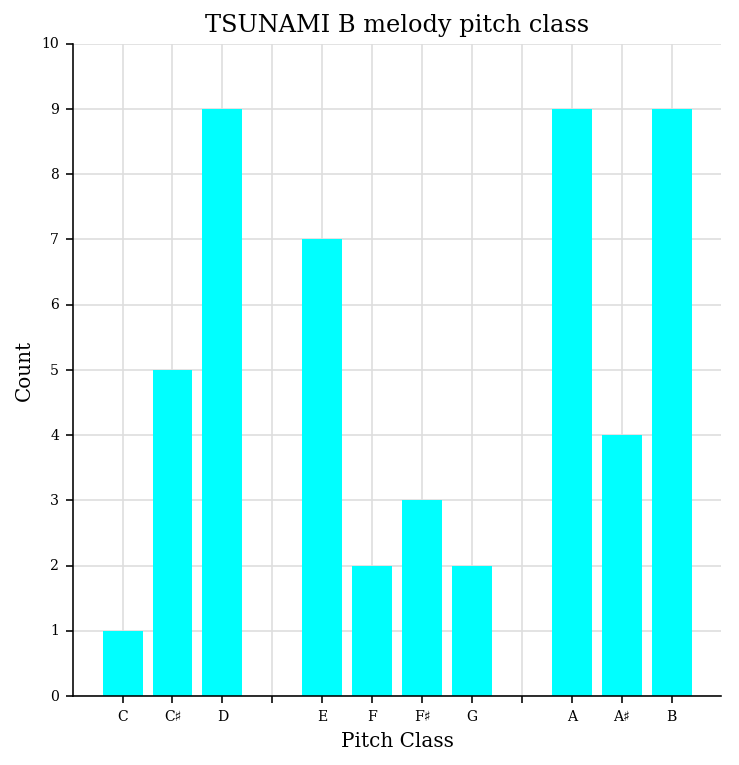

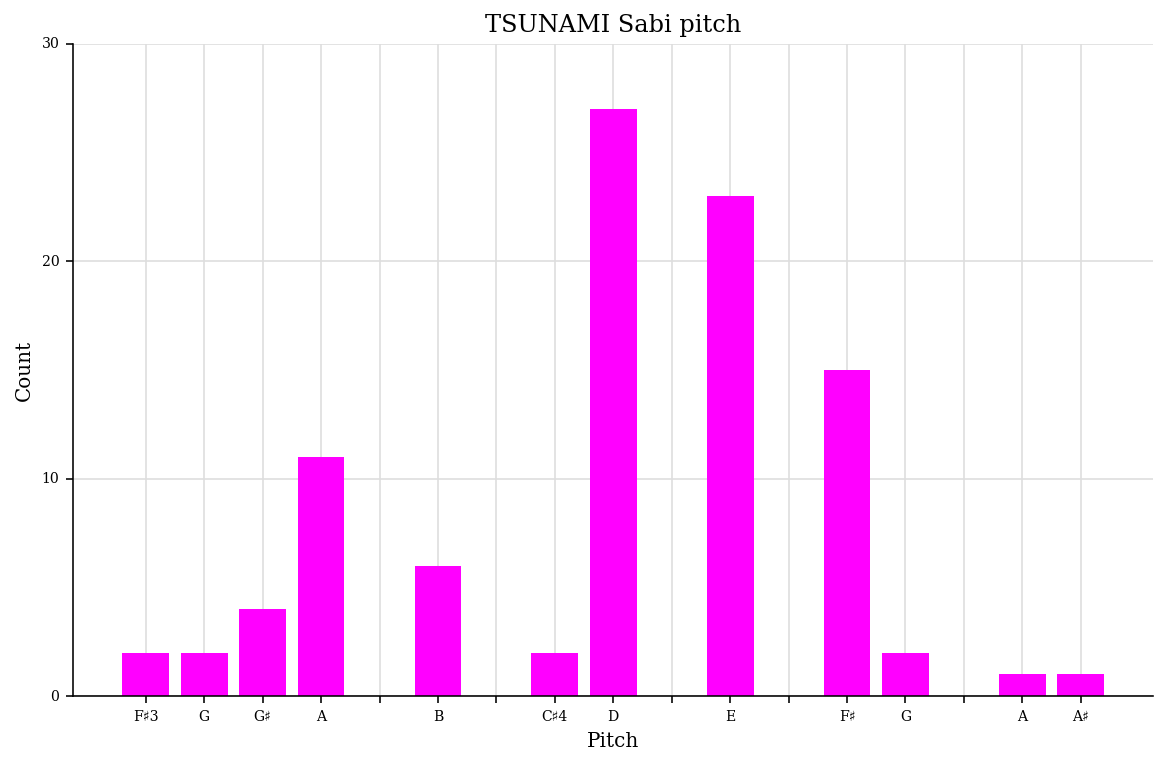

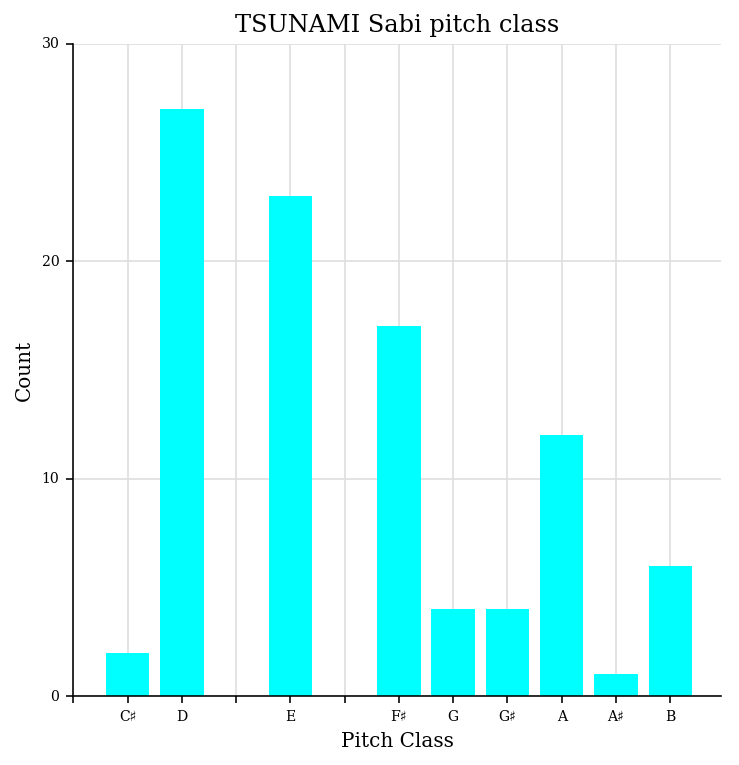

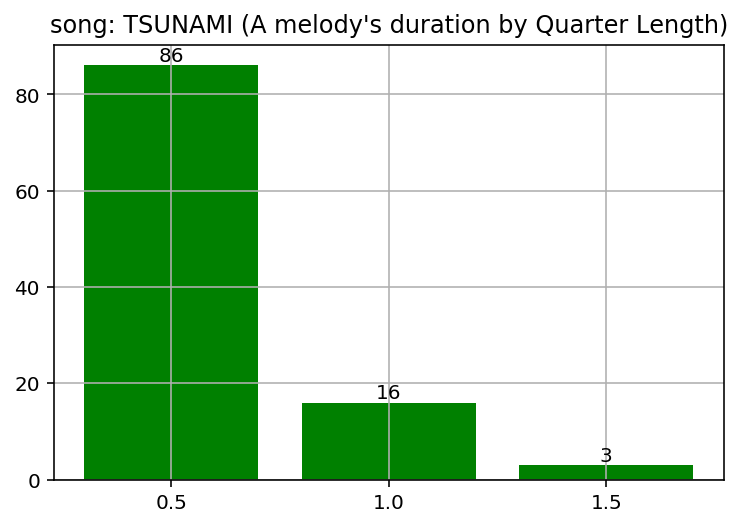

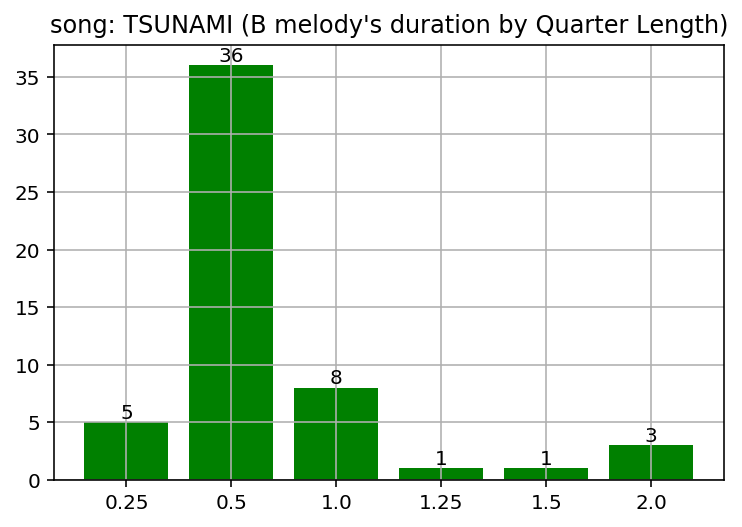

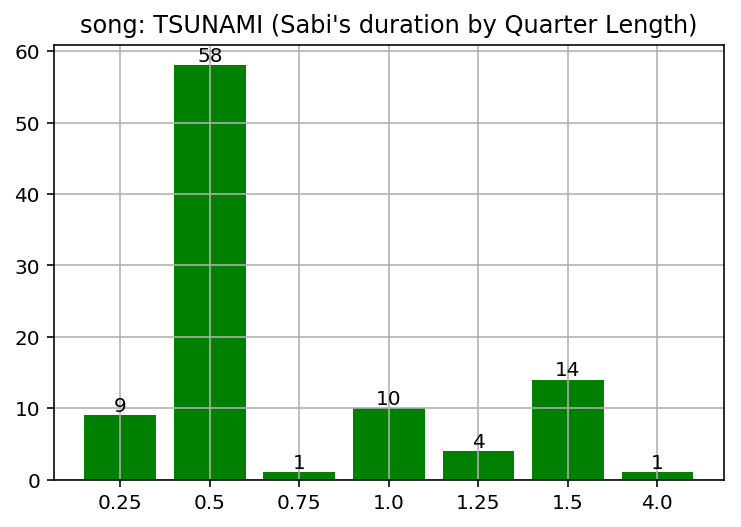

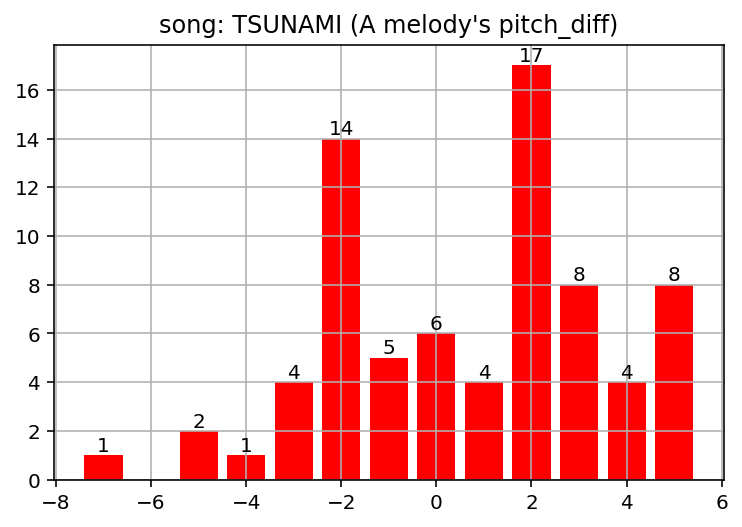

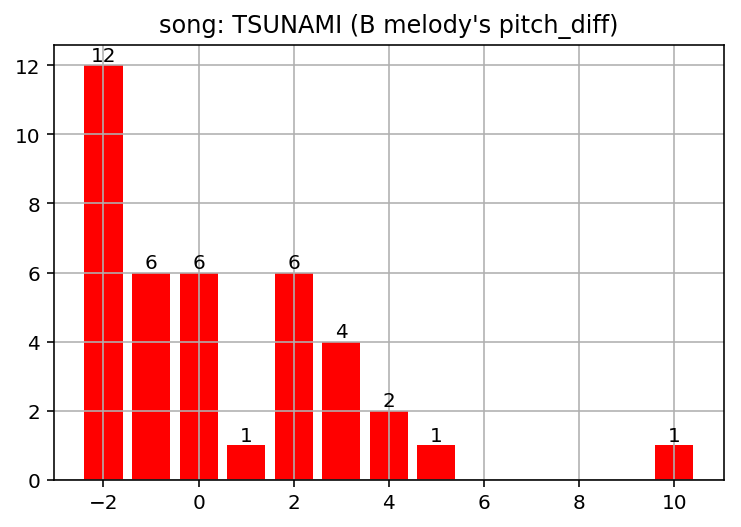

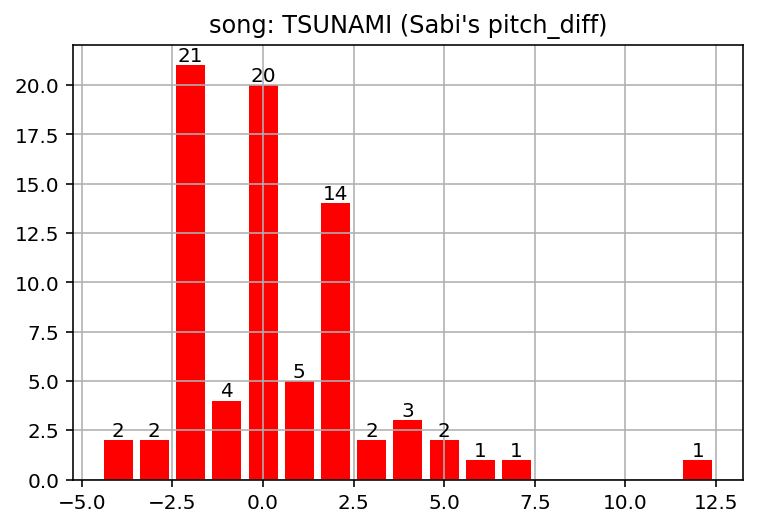

A melodyの跳躍情報　跳躍の割合:0.38,上向跳躍の割合:0.27,下降跳躍の割合:0.11
B melodyの跳躍情報　跳躍の割合:0.21,上向跳躍の割合:0.21,下降跳躍の割合:0.0
Sabiの跳躍情報　跳躍の割合:0.18,上向跳躍の割合:0.13,下降跳躍の割合:0.051
A melodyの音域情報　最高音:E4,最低音:A2,音域:19半音
B melodyの音域情報　最高音:E4,最低音:D3,音域:14半音
Sabiの音域情報　最高音:B-4,最低音:F#3,音域:16半音
------------Roman Hikou-------------
-------A melodyの統計情報---------
調:B major
-------B melodyの統計情報---------
調:g# minor
-------Sabiの統計情報---------
調:B major


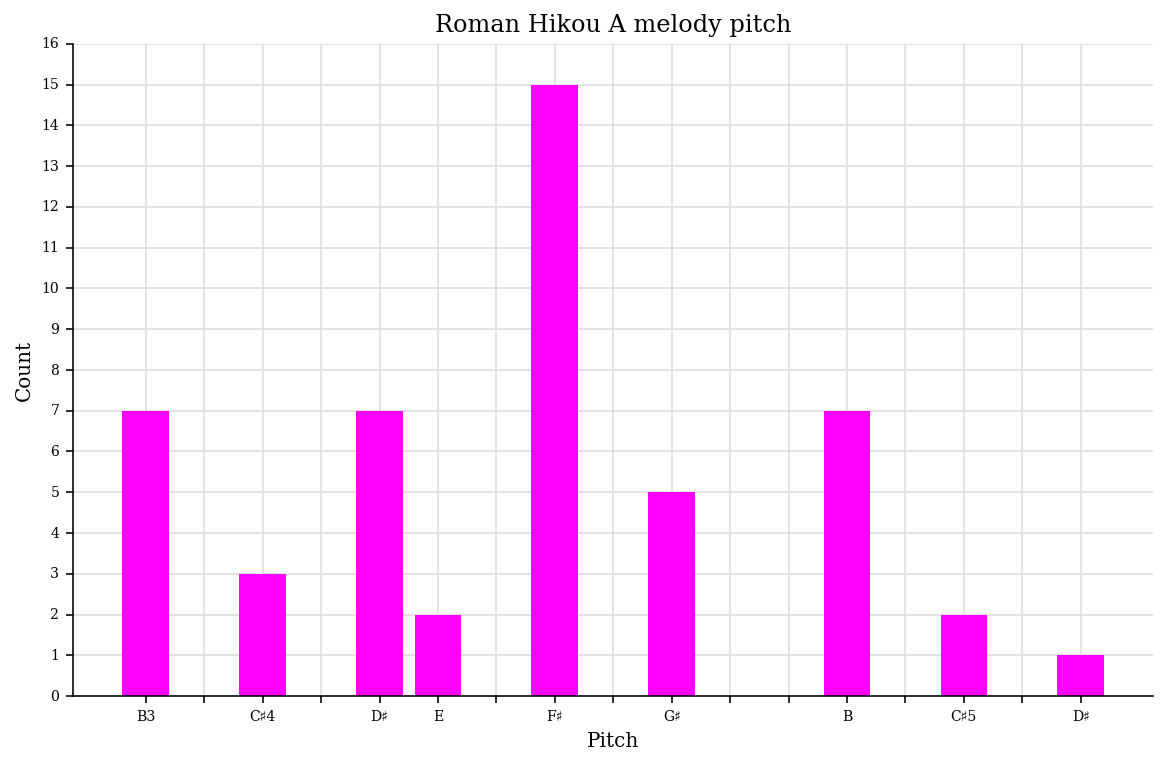

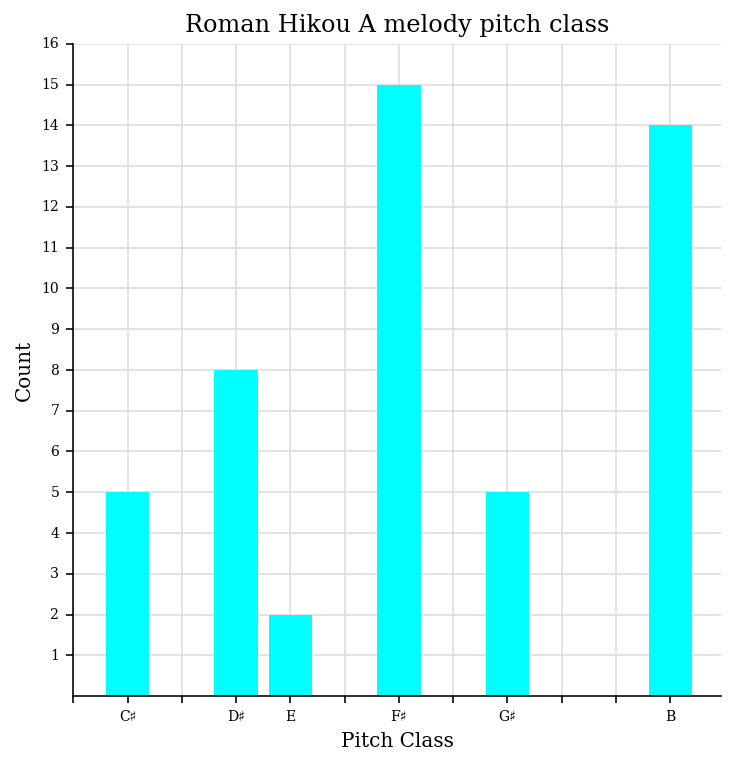

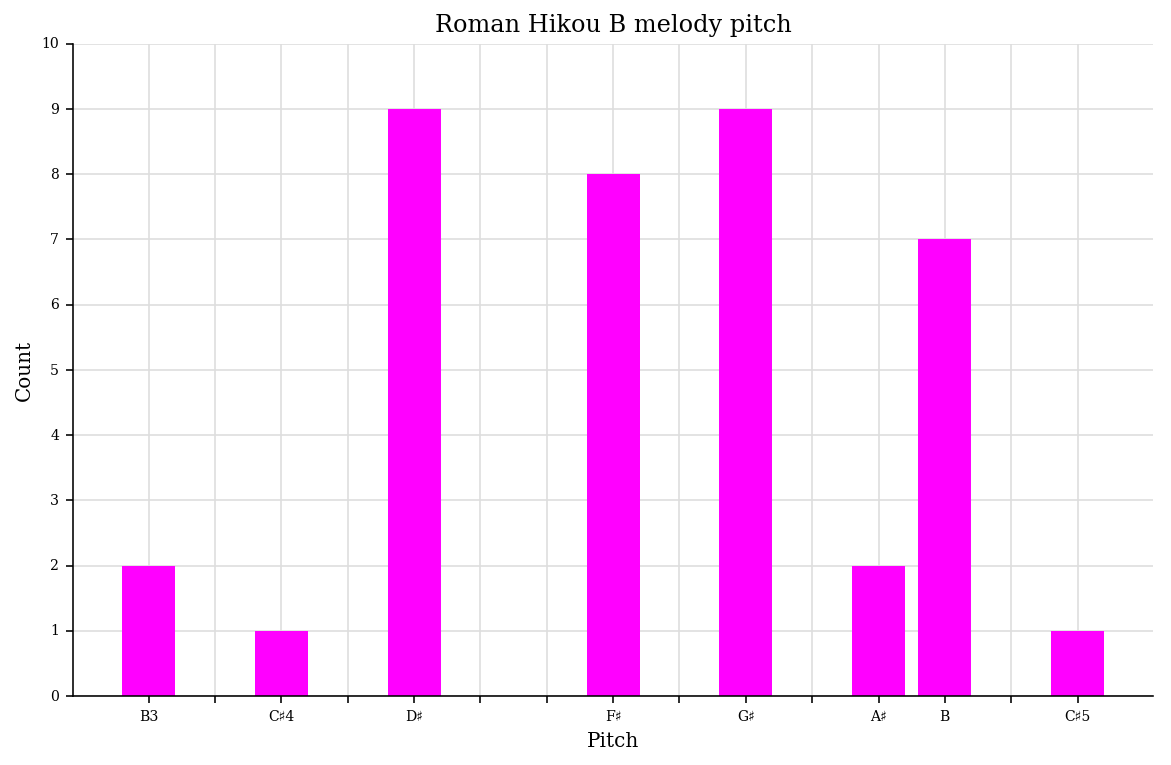

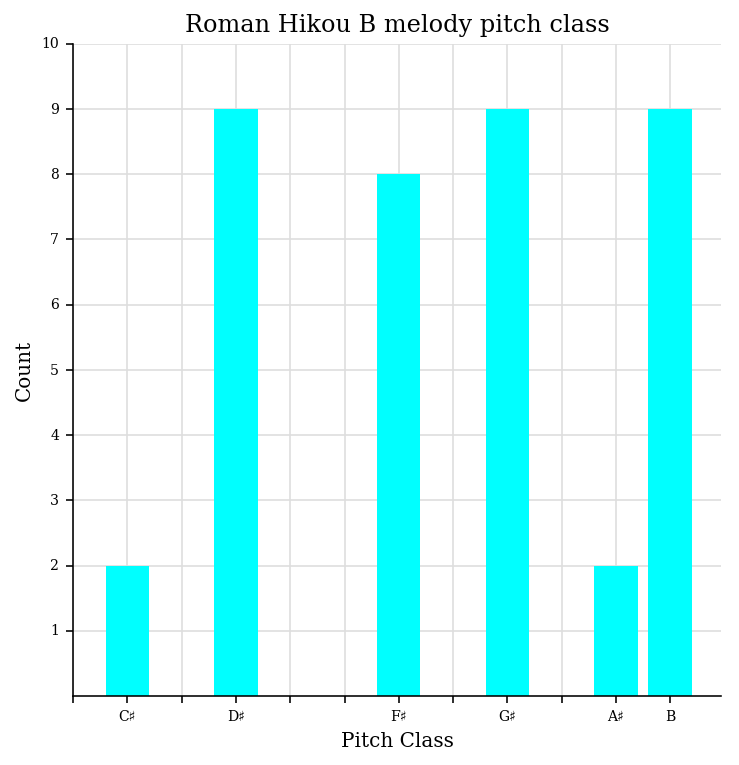

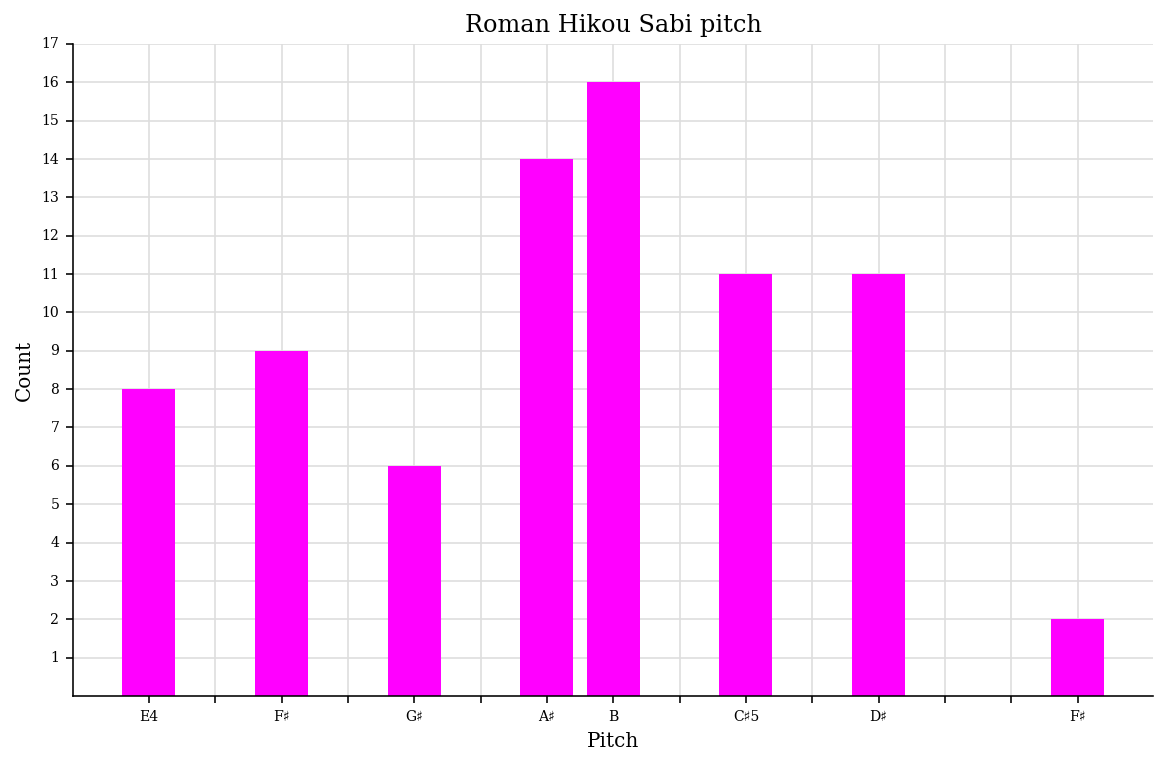

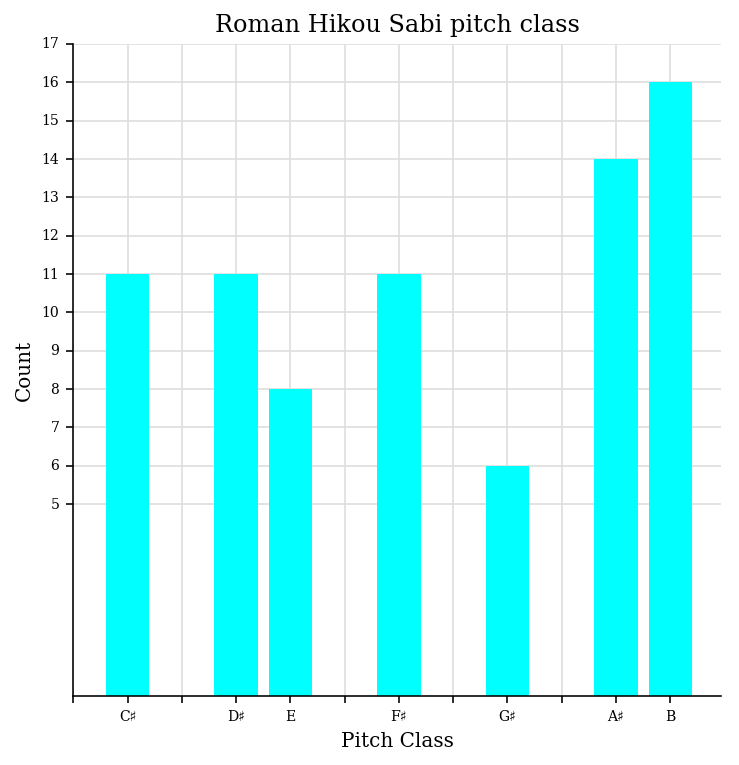

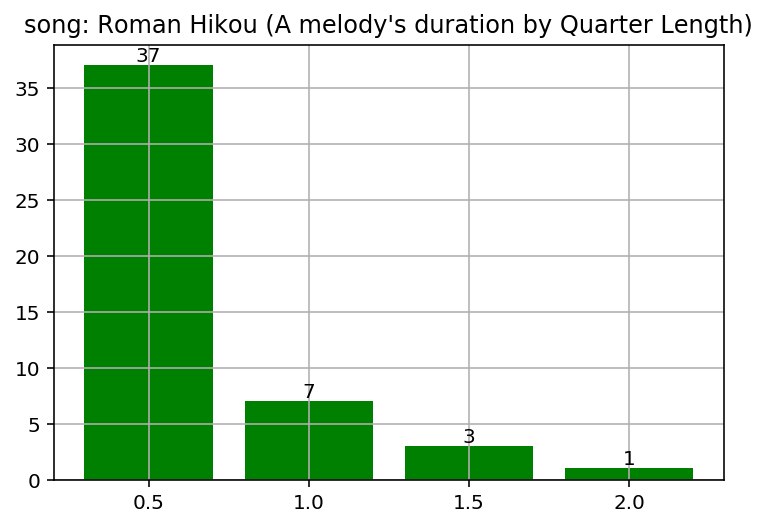

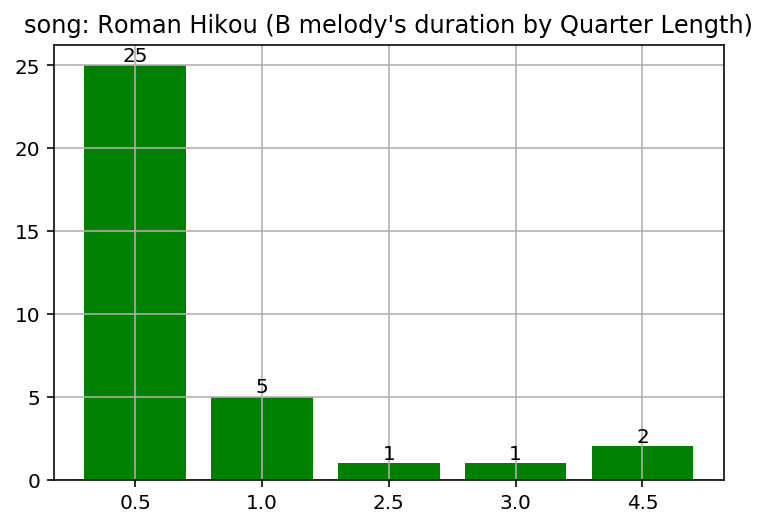

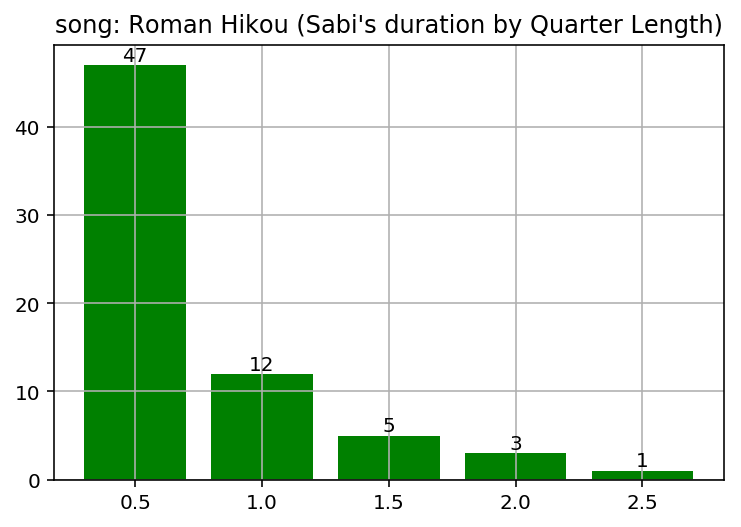

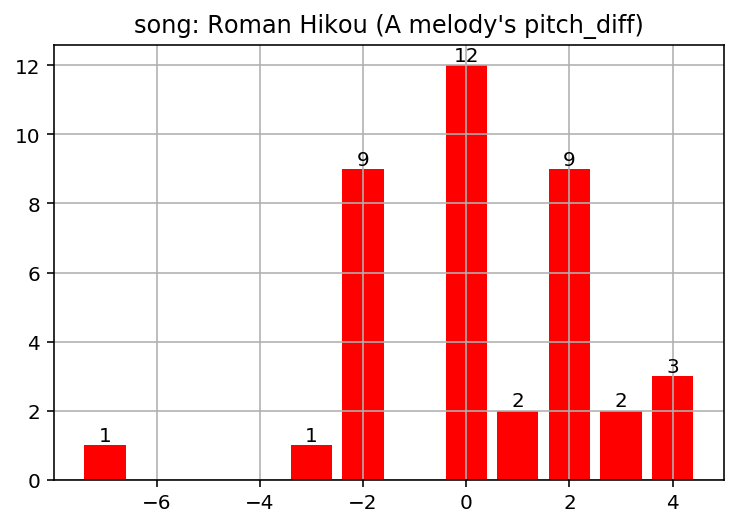

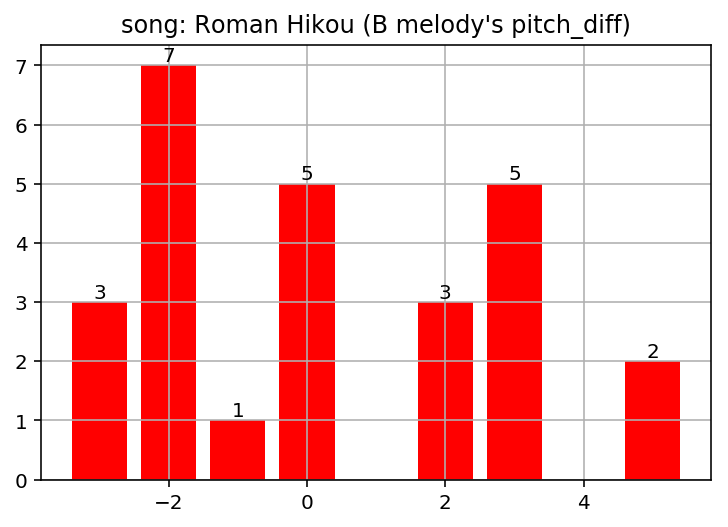

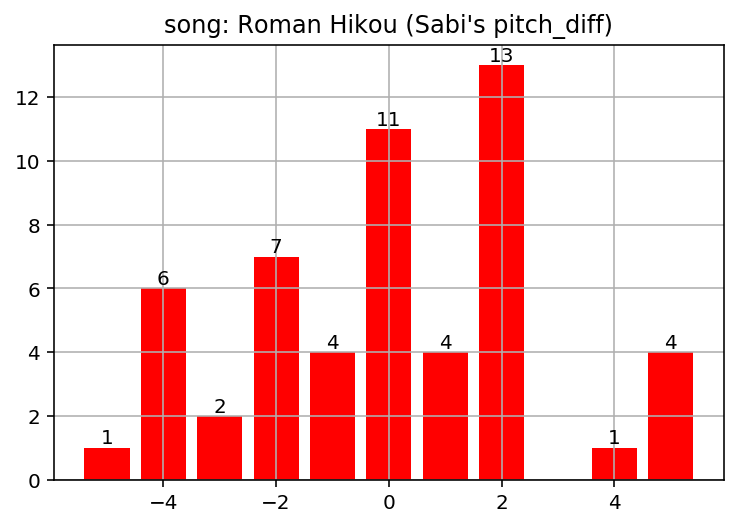

A melodyの跳躍情報　跳躍の割合:0.18,上向跳躍の割合:0.13,下降跳躍の割合:0.051
B melodyの跳躍情報　跳躍の割合:0.38,上向跳躍の割合:0.27,下降跳躍の割合:0.12
Sabiの跳躍情報　跳躍の割合:0.26,上向跳躍の割合:0.094,下降跳躍の割合:0.17
A melodyの音域情報　最高音:D#5,最低音:B3,音域:16半音
B melodyの音域情報　最高音:C#5,最低音:B3,音域:14半音
Sabiの音域情報　最高音:F#5,最低音:E4,音域:14半音
------------Aporo-------------
-------A melodyの統計情報---------
調:e minor
-------B melodyの統計情報---------
調:e minor
-------Sabiの統計情報---------
調:e minor


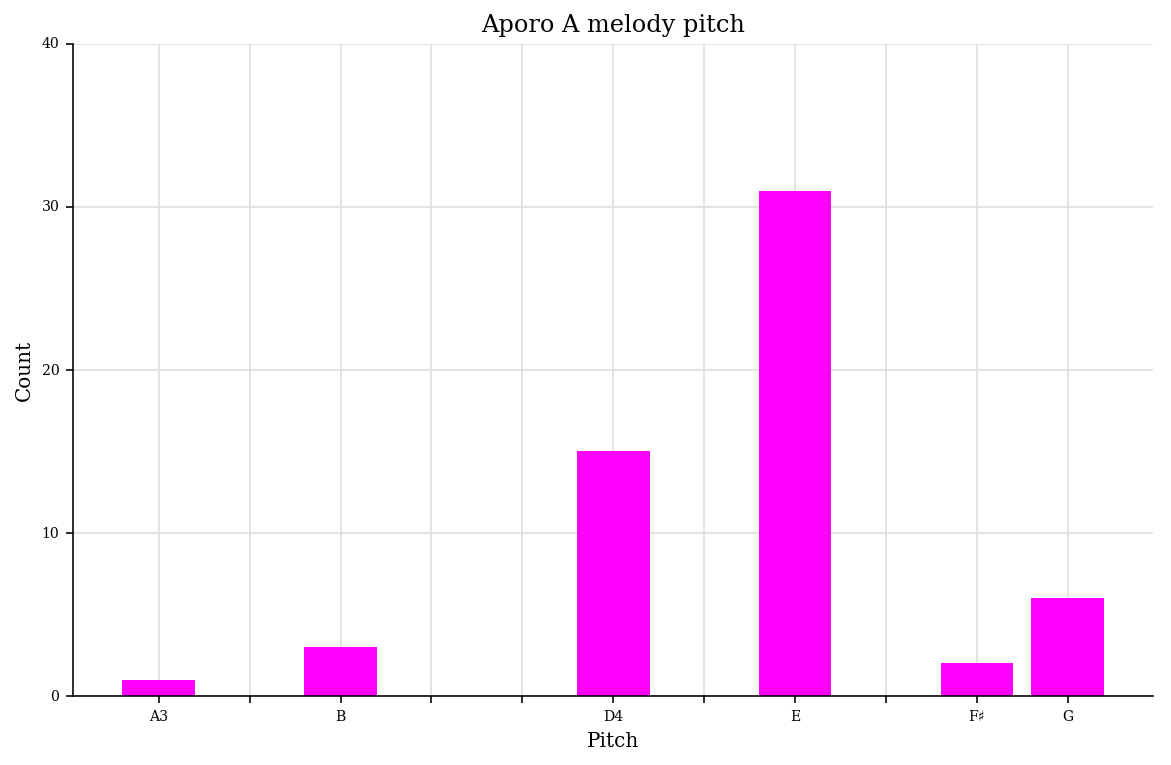

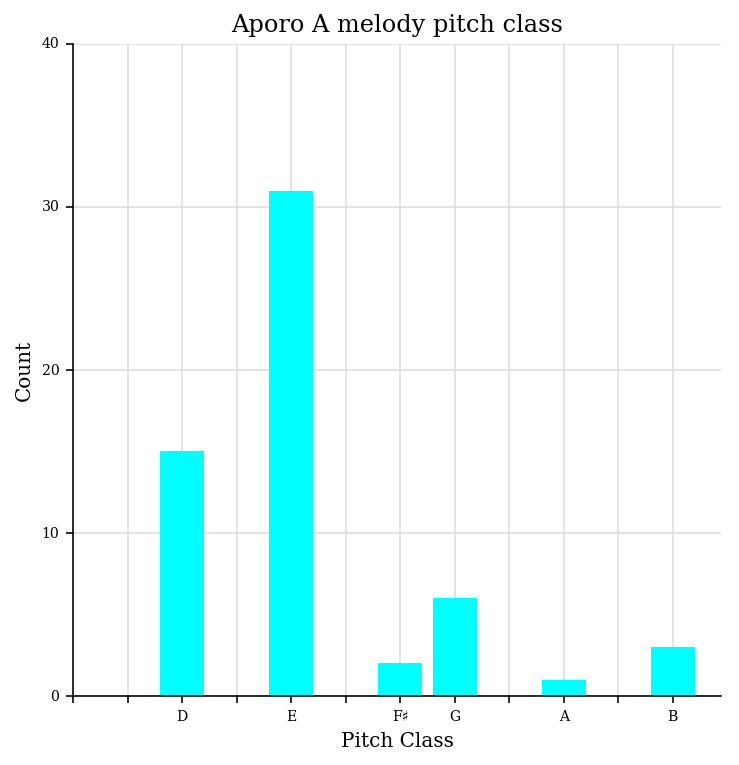

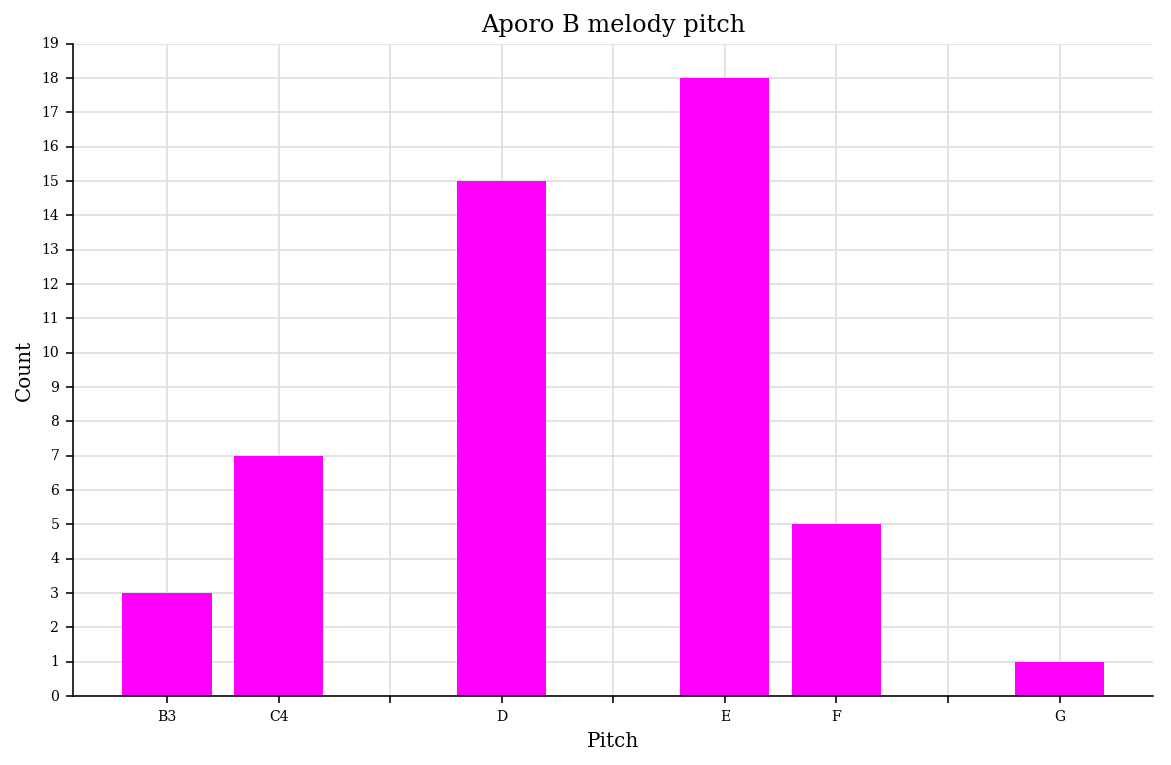

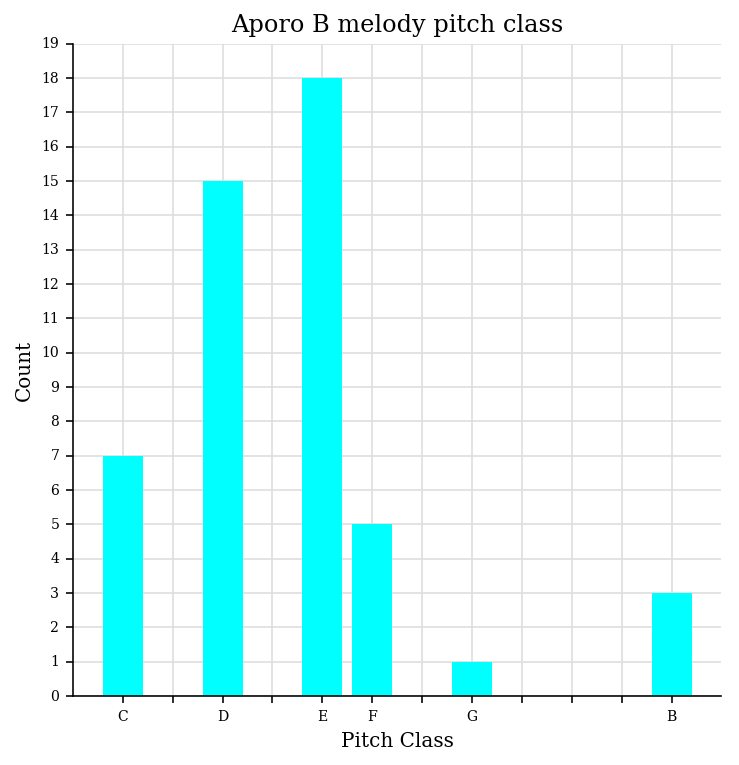

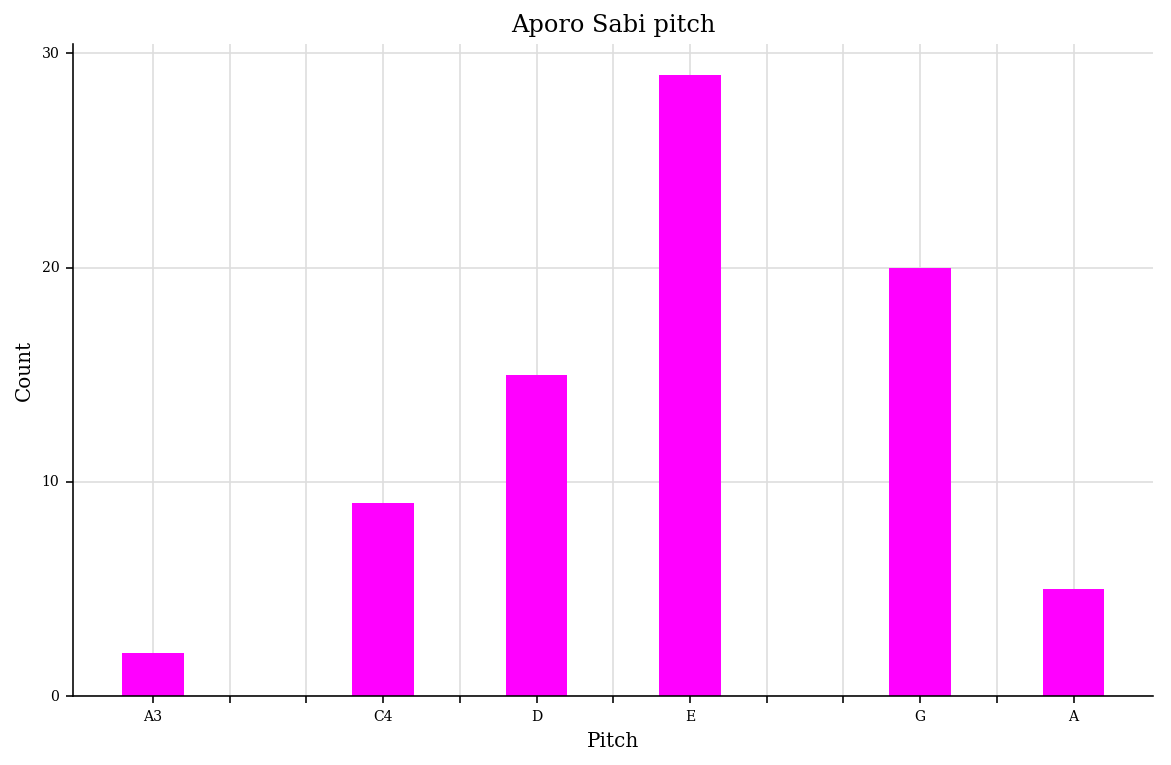

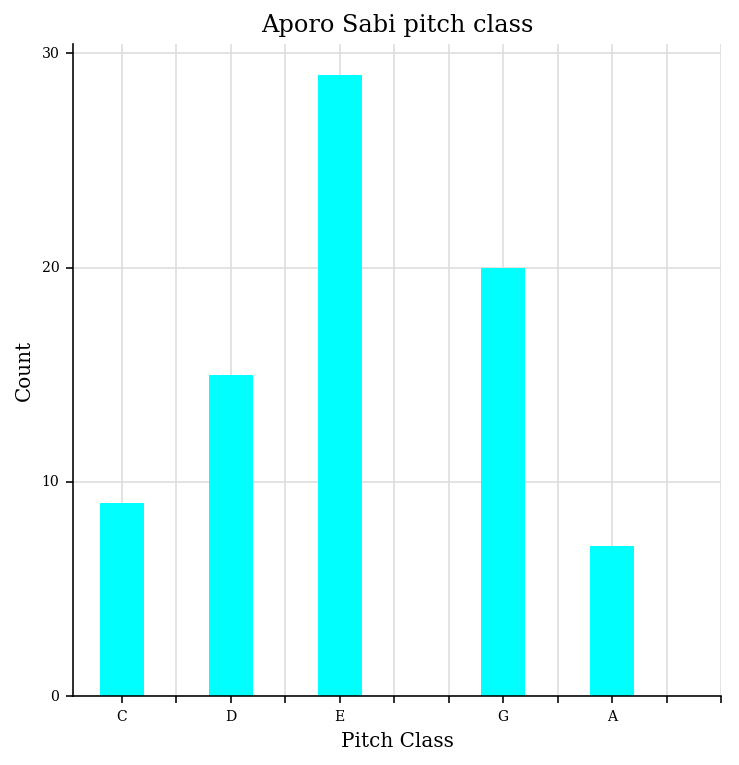

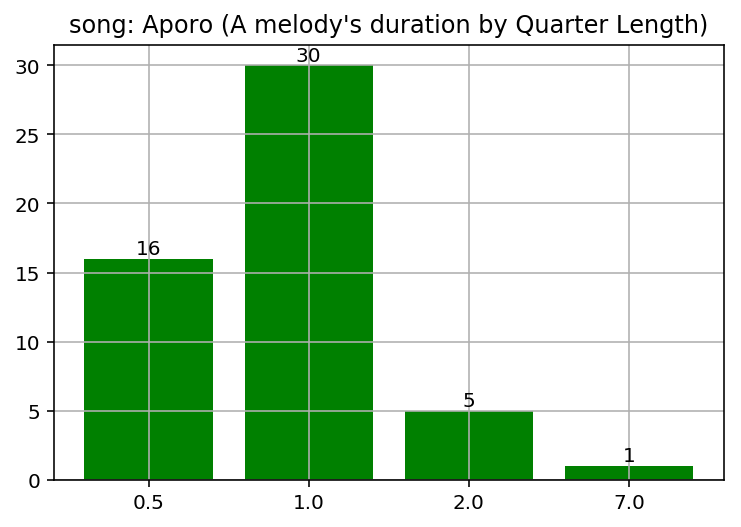

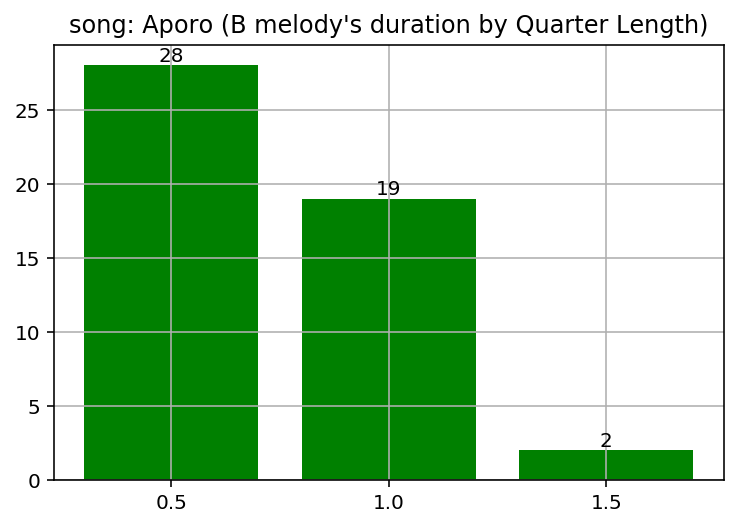

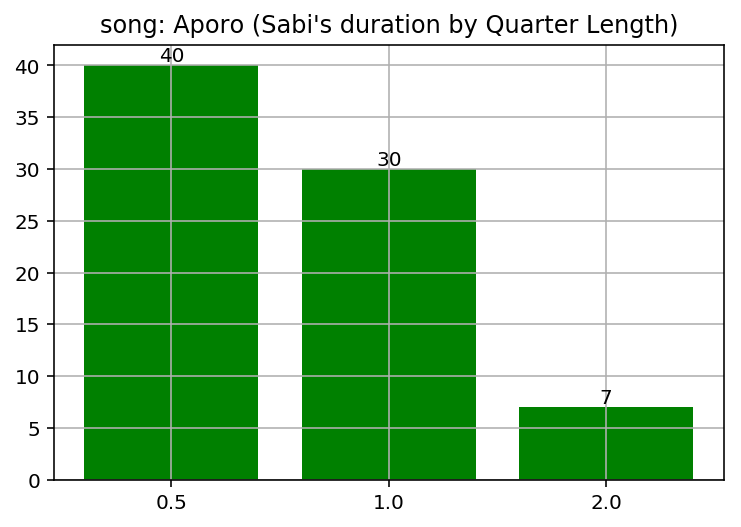

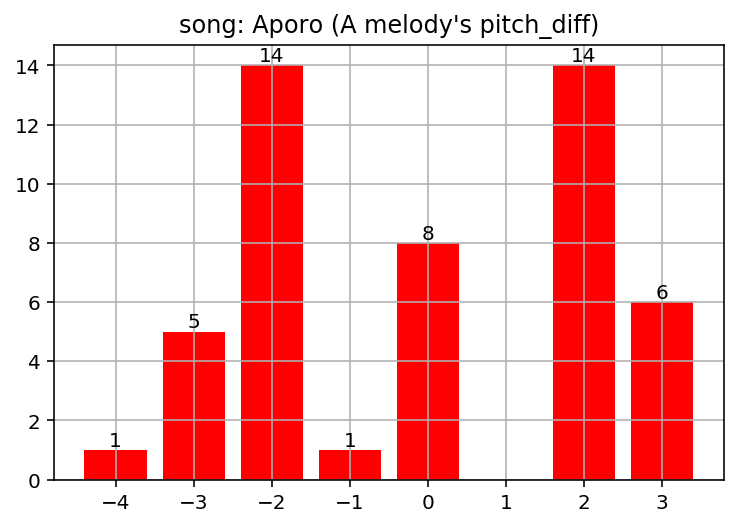

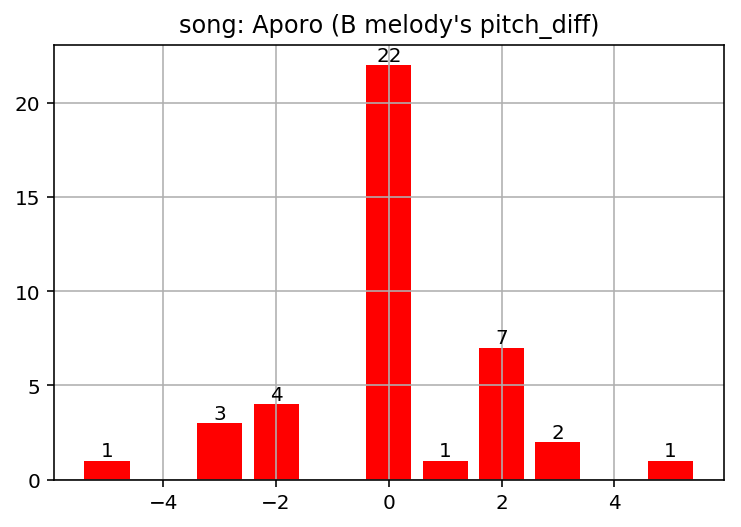

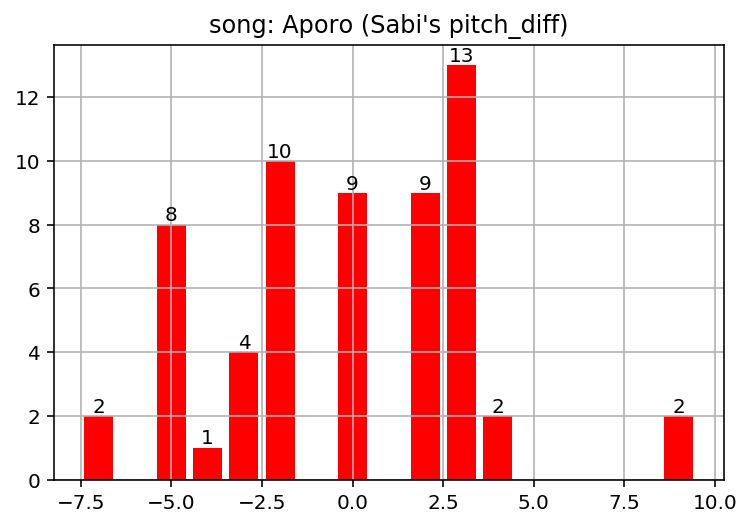

A melodyの跳躍情報　跳躍の割合:0.24,上向跳躍の割合:0.12,下降跳躍の割合:0.12
B melodyの跳躍情報　跳躍の割合:0.17,上向跳躍の割合:0.073,下降跳躍の割合:0.098
Sabiの跳躍情報　跳躍の割合:0.53,上向跳躍の割合:0.28,下降跳躍の割合:0.25
A melodyの音域情報　最高音:G4,最低音:A3,音域:10半音
B melodyの音域情報　最高音:G4,最低音:B3,音域:8半音
Sabiの音域情報　最高音:A4,最低音:A3,音域:12半音
------------Guren No Yumiya-------------
-------A melodyの統計情報---------
調:F# major
-------B melodyの統計情報---------
調:C# major
-------Sabiの統計情報---------
調:c# minor


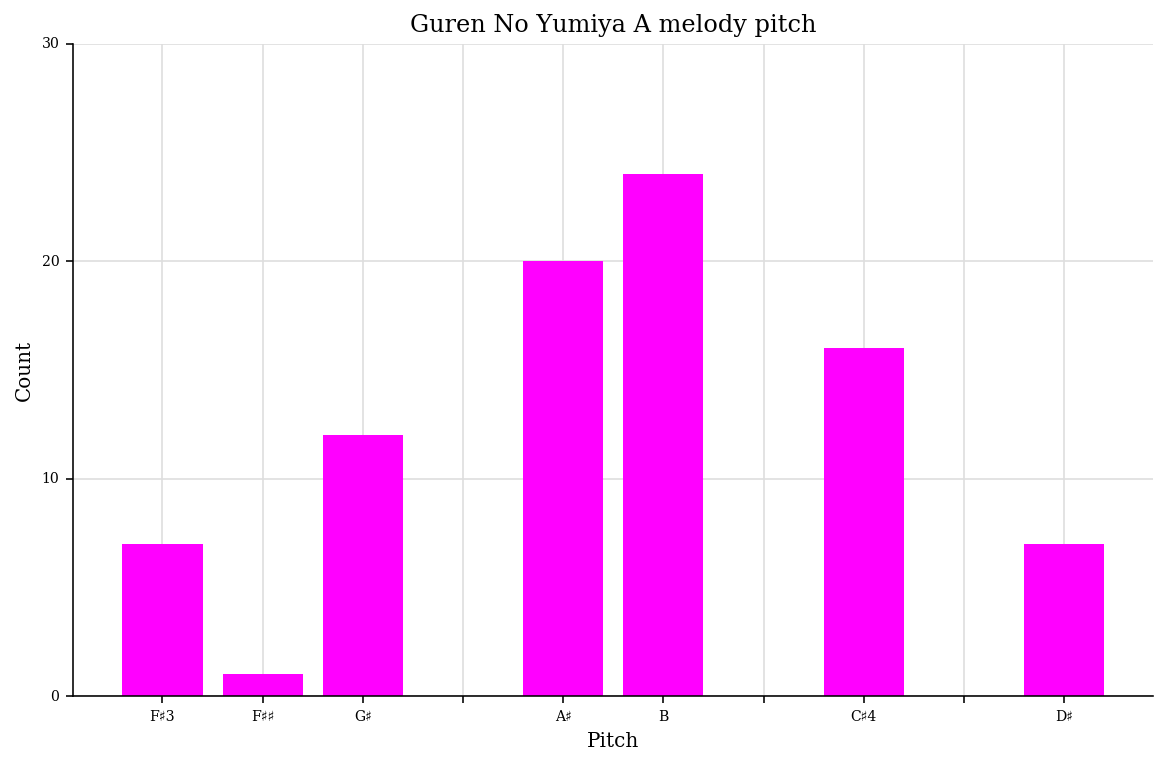

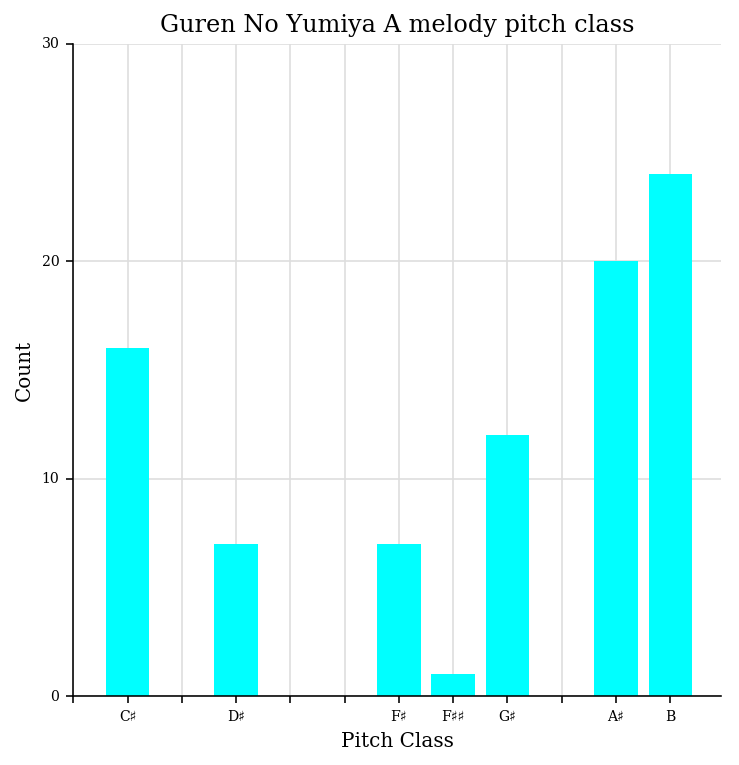

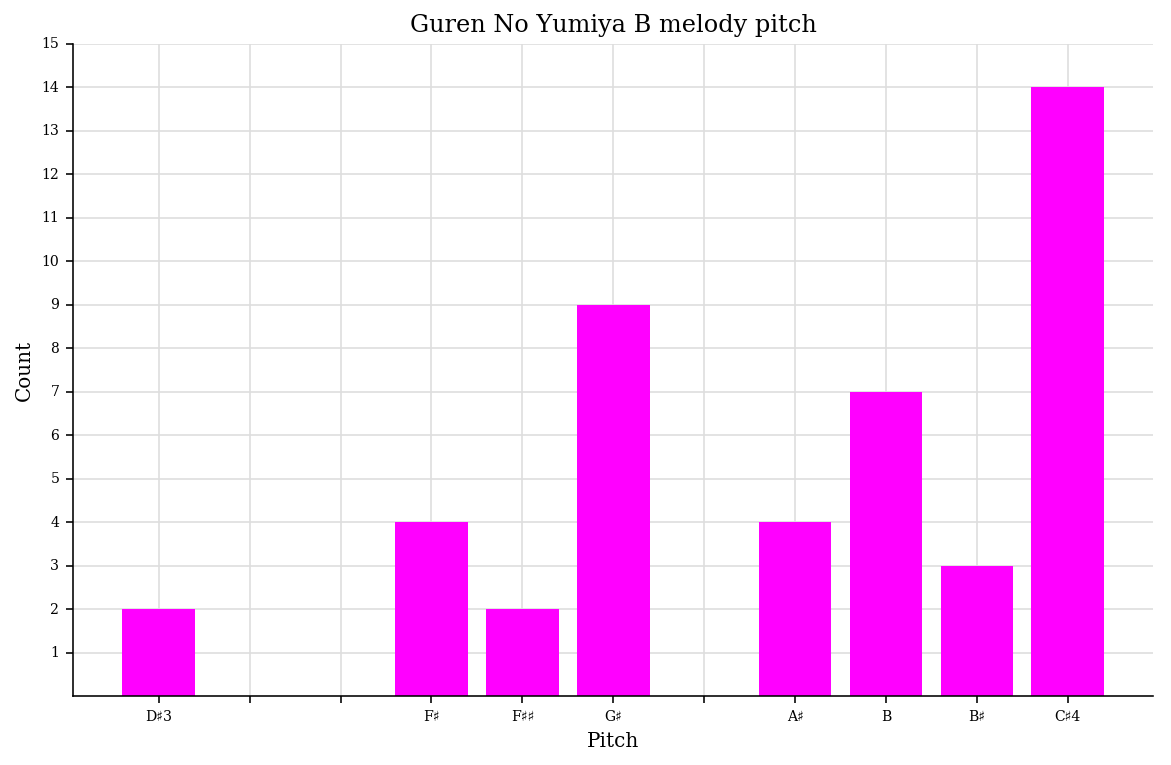

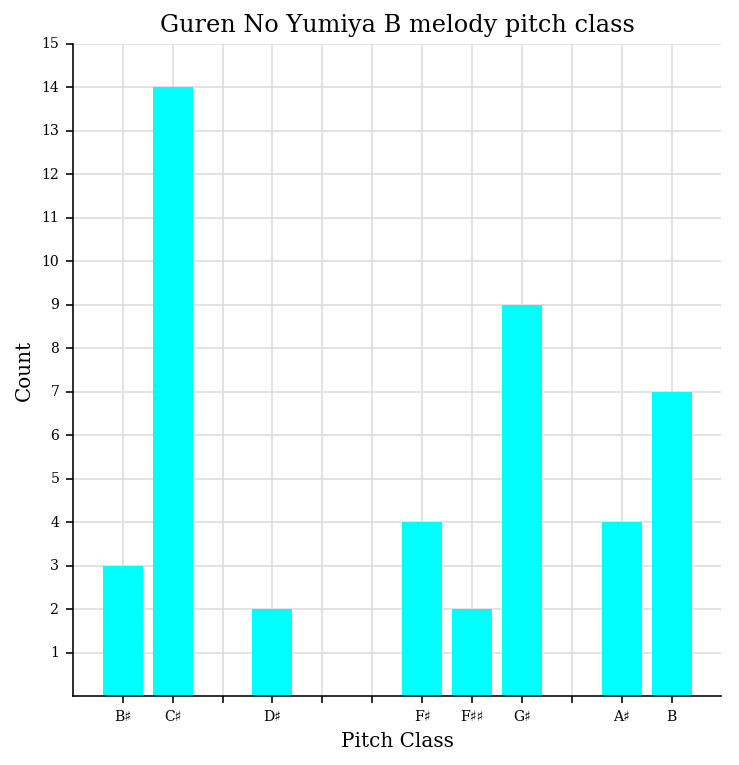

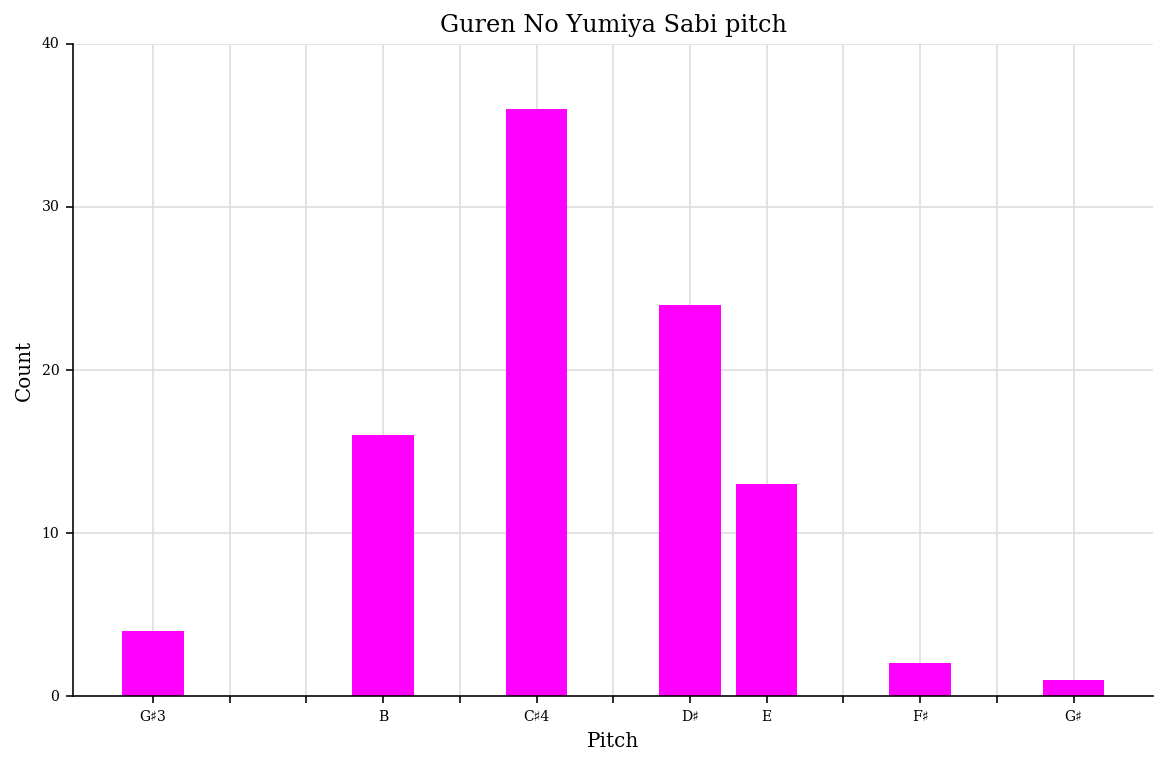

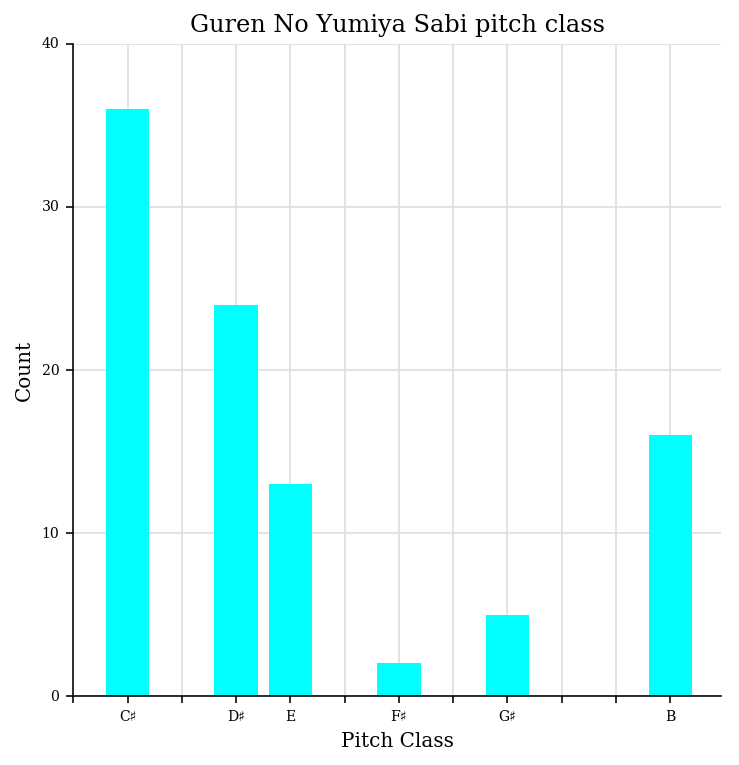

In [ ]:
for sheets in analysis_corpus:
    sheets.show_key()
    sheets.counting_pitch()
    plt.figure()
    sheets.counting_duration()
    plt.figure()
    sheets.plot_pitch_diff()
    sheets.calucurate_jump()
    sheets.caluculate_pitch_range()

### 歌唱実験アンケート

+ CSVデータの出力
+ セクションごとの主観難易度


In [19]:
difficulty = {"メロディが複雑で正確に音程を取りづらい":0,"音の飛びが激しく音程がとれない":1,"音域が広い":2,"テンポが速い":3,"リズムが複雑でわかりにくい":4," 16分音符などが多くてリズムが細かい":5,"ロングトーンがあったり息継ぎタイミングがわかりにくく肺活量的に無理がある":6,"英語の歌詞":7,"シャウトやビブラートなど特殊奏法":8,"other":9,np.nan:100}

def difficulty_to_tag(string):
    if type(string) == float:
        print("nannan")
    else:
        #難易度の理由が複数コンマとスペース区切りで入力
        array = []
        #解析可能な形のリストに区切る
        words = string.split(", ")  
        for word in words:
            print(word)
            if word in difficulty:
                print("ireruyo-{}".format(str(word)))
                array.append(difficulty[word])
            else:
                array.append(difficulty["other"])
            print(array)
        return array

In [ ]:
df = pd.read_csv("yobijikken.csv")

In [21]:
ritch_df = df.query() 

,time_stamp,age,sex,singing_competence,song,amero_difficulty,amero_reason,amero_reason_free,bmero_difficulty,bmero_reason,bmero_reason_free,sabi_difficulty,sabi_reason,sabi_reason_free,preference,memorized,frequency,listenable,other
0,1,23,男性,3,チェリー,2,滑らかに歌うことが難しいAメロだったから。,NaN,1,メロディが複雑で正確に音程を取りづらい,NaN,3,メロディが複雑で正確に音程を取りづらい,NaN,3,完璧に覚えている,1,3,NaN
1,1,23,男性,3,TSUNAMI,1,自分の音域に合っている,NaN,1,自分の音域に合っている,NaN,2,音程の移り変わりが比較的単調であり、かつテンポがゆるい,NaN,3,だいたいは覚えている,2,2,NaN
2,1,23,男性,3,紅蓮の弓矢,2,音域が滑らかに推移しており極端な上下が無い。,NaN,3,ロングトーンがあったり息継ぎタイミングがわかりにくく肺活量的に無理がある,NaN,3,リズムが複雑でわかりにくい,NaN,3,だいたいは覚えている,1,2,NaN
3,1,23,男性,3,浪漫飛行,3,メロディが複雑で正確に音程を取りづらい,NaN,2,メロディが複雑で正確に音程を取りづらい,NaN,3,音の飛びが激しく音程がとれない,NaN,2,だいたいは覚えている,1,2,NaN
4,1,23,男性,3,アポロ,1,"テンポが速い, テンポは早いが音域がそこまで広くはない印象",NaN,3,ロングトーンがあったり息継ぎタイミングがわかりにくく肺活量的に無理がある,NaN,4,"ロングトーンがあったり息継ぎタイミングがわかりにくく肺活量的に無理がある, いきなり高音から...",NaN,3,完璧に覚えている,2,3,NaN
5,1,23,男性,3,粉雪,1,音の推移が緩やかでテンポも遅い。,NaN,1,テンポが緩く音域が自分に合っているから。,NaN,3,音域が広い,NaN,3,完璧に覚えている,2,3,NaN
6,2,21,男性,3,チェリー,1,ロングトーンがあったり息継ぎタイミングがわかりにくく肺活量的に無理がある,NaN,1,"ロングトーンがあったり息継ぎタイミングがわかりにくく肺活量的に無理がある, なし",NaN,1,音域が広い,NaN,4,完璧に覚えている,1,4,NaN
7,2,21,男性,3,TSUNAMI,2,"音の飛びが激しく音程がとれない, 始まりの音が低く、当てられない",NaN,2,"音の飛びが激しく音程がとれない, 音が上下に変わるので、正確に当てづらい",NaN,1,音域が広い,NaN,4,完璧に覚えている,1,4,NaN
8,2,21,男性,3,紅蓮の弓矢,2,"リズムが複雑でわかりにくい, 英語の歌詞, 低い音がとりづらい",NaN,3,"音の飛びが激しく音程がとれない, テンポが速い, ｢進む意思よ笑う豚よ｣(？)の音の飛び方が難しい",NaN,1,テンポが速い,NaN,3,あまり覚えてない,1,1,NaN
9,2,21,男性,3,浪漫飛行,3,"メロディが複雑で正確に音程を取りづらい, 音域が広い",NaN,4,"メロディが複雑で正確に音程を取りづらい, オク下で歌っているため、低いところ｢夢を見てよ、な...",NaN,2,ロングトーンがあったり息継ぎタイミングがわかりにくく肺活量的に無理がある,NaN,2,だいたいは覚えている,1,4,NaN


In [245]:
type(np.nan) == float

True

In [25]:
#扱いやすいよう理由を数字に変換
for num,reason in enumerate(df["amero_reason"]):
    print(num)
    print(reason)
    a = difficulty_to_tag(reason)
    df["sabi_reason"][num] = str(a).strip("[").strip("]")
for num,reason in enumerate(df["bmero_reason"]):
    print(num)
    print(reason)
    a = difficulty_to_tag(reason)
    df["sabi_reason"][num] = str(a).strip("[").strip("]")
for num,reason in enumerate(df["sabi_reason"]):
    print(num)
    print(reason)
    a = difficulty_to_tag(reason)
    df["sabi_reason"][num] = str(a).strip("[").strip("]")

0
メロディが複雑で正確に音程を取りづらい
メロディが複雑で正確に音程を取りづらい
ireruyo-メロディが複雑で正確に音程を取りづらい

C:\Users\match\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0]
1
音程の移り変わりが比較的単調であり、かつテンポがゆるい
音程の移り変わりが比較的単調であり、かつテンポがゆるい
[9]
2
リズムが複雑でわかりにくい
リズムが複雑でわかりにくい
ireruyo-リズムが複雑でわかりにくい
[4]
3
音の飛びが激しく音程がとれない
音の飛びが激しく音程がとれない
ireruyo-音の飛びが激しく音程がとれない
[1]
4
ロングトーンがあったり息継ぎタイミングがわかりにくく肺活量的に無理がある, いきなり高音から始まるので当てるのが難しい
ロングトーンがあったり息継ぎタイミングがわかりにくく肺活量的に無理がある
ireruyo-ロングトーンがあったり息継ぎタイミングがわかりにくく肺活量的に無理がある
[6]
いきなり高音から始まるので当てるのが難しい
[6, 9]
5
音域が広い
音域が広い
ireruyo-音域が広い
[2]
6
音域が広い
音域が広い
ireruyo-音域が広い
[2]
7
音域が広い
音域が広い
ireruyo-音域が広い
[2]
8
テンポが速い
テンポが速い
ireruyo-テンポが速い
[3]
9
ロングトーンがあったり息継ぎタイミングがわかりにくく肺活量的に無理がある
ロングトーンがあったり息継ぎタイミングがわかりにくく肺活量的に無理がある
ireruyo-ロングトーンがあったり息継ぎタイミングがわかりにくく肺活量的に無理がある
[6]
10
音域が広い, テンポが速い
音域が広い
ireruyo-音域が広い
[2]
テンポが速い
ireruyo-テンポが速い
[2, 3]
11
音域が広い, 音が高く、むせた
音域が広い
ireruyo-音域が広い
[2]
音が高く、むせた
[2, 9]
12
音の飛びが激しく音程がとれない, リズムが複雑でわかりにくい, 音が飛ぶ部分があり油断すると外す。
音の飛びが激しく音程がとれない
ireruyo-音の飛びが激しく音程がとれない
[1]
リズムが複雑でわかりにくい
ireruyo-リズムが複雑でわかりにくい
[1, 4]
音が飛ぶ部分があり油断すると外す。
[1, 4, 9]
13
シャウトやビブラートなど特殊奏法
シャウトやビブラートなど特殊奏法
ireruyo-シャウトやビブラートなど特殊奏法
[8]
14
リズムが複雑でわかりにくい, 1

In [26]:
df

,time_stamp,age,sex,singing_competence,song,amero_difficulty,amero_reason,amero_reason_free,bmero_difficulty,bmero_reason,bmero_reason_free,sabi_difficulty,sabi_reason,sabi_reason_free,preference,memorized,frequency,listenable,other
0,1,23,男性,3,チェリー,2,9,NaN,1,0,NaN,3,0,NaN,3,完璧に覚えている,1,3,NaN
1,1,23,男性,3,TSUNAMI,1,9,NaN,1,9,NaN,2,9,NaN,3,だいたいは覚えている,2,2,NaN
2,1,23,男性,3,紅蓮の弓矢,2,9,NaN,3,6,NaN,3,4,NaN,3,だいたいは覚えている,1,2,NaN
3,1,23,男性,3,浪漫飛行,3,0,NaN,2,0,NaN,3,1,NaN,2,だいたいは覚えている,1,2,NaN
4,1,23,男性,3,アポロ,1,"3, 9",NaN,3,6,NaN,4,"6, 9",NaN,3,完璧に覚えている,2,3,NaN
5,1,23,男性,3,粉雪,1,9,NaN,1,9,NaN,3,2,NaN,3,完璧に覚えている,2,3,NaN
6,2,21,男性,3,チェリー,1,6,NaN,1,"6, 9",NaN,1,2,NaN,4,完璧に覚えている,1,4,NaN
7,2,21,男性,3,TSUNAMI,2,"1, 9",NaN,2,"1, 9",NaN,1,2,NaN,4,完璧に覚えている,1,4,NaN
8,2,21,男性,3,紅蓮の弓矢,2,"4, 7, 9",NaN,3,"1, 3, 9",NaN,1,3,NaN,3,あまり覚えてない,1,1,NaN
9,2,21,男性,3,浪漫飛行,3,"0, 2",NaN,4,"0, 9",NaN,2,6,NaN,2,だいたいは覚えている,1,4,NaN


In [30]:
songs = ["チェリー","TSUNAMI","紅蓮の弓矢","浪漫飛行","アポロ","粉雪"]

In [31]:
def make_count_query(song,koumoku):
    #バグがでます
    print(df.query("song.str.contains("+song+")",engine="python")[koumoku].value.sounts())

In [32]:
make_count_query("チェリー","amero_difficulty")

UndefinedVariableError: name 'チェリー' is not defined

In [34]:
#Aメロの難易度を集計

print(songs[0])
print(df.query('song.str.contains("チェリー")', engine='python')["amero_difficulty"].value_counts())
print(df.query('song.str.contains("チェリー")', engine='python')["amero_difficulty"].mean())
print(songs[1])
print(df.query('song.str.contains("TSUNAMI")', engine='python')["amero_difficulty"].value_counts())
print(df.query('song.str.contains("TSUNAMI")', engine='python')["amero_difficulty"].mean())
print(songs[2])
print(df.query('song.str.contains("紅蓮の弓矢")', engine='python')["amero_difficulty"].value_counts())
print(df.query('song.str.contains("紅蓮の弓矢")', engine='python')["amero_difficulty"].mean())
print(songs[3])
print(df.query('song.str.contains("浪漫飛行")', engine='python')["amero_difficulty"].value_counts())
print(df.query('song.str.contains("浪漫飛行")', engine='python')["amero_difficulty"].mean())
print(songs[4])
print(df.query('song.str.contains("アポロ")', engine='python')["amero_difficulty"].value_counts())
print(df.query('song.str.contains("アポロ")', engine='python')["amero_difficulty"].mean())
print(songs[5])
print(df.query('song.str.contains("粉雪")', engine='python')["amero_difficulty"].value_counts())
print(df.query('song.str.contains("粉雪")', engine='python')["amero_difficulty"].mean())
print("====Aメロ合計====\n{}".format(df["amero_difficulty"].value_counts()))

チェリー
2    3
1    2
3    1
Name: amero_difficulty, dtype: int64
1.8333333333333333
TSUNAMI
3    2
2    2
1    1
Name: amero_difficulty, dtype: int64
2.2
紅蓮の弓矢
2    3
4    1
Name: amero_difficulty, dtype: int64
2.5
浪漫飛行
3    3
4    1
1    1
Name: amero_difficulty, dtype: int64
2.8
アポロ
3    2
2    2
1    1
Name: amero_difficulty, dtype: int64
2.2
粉雪
1    3
3    2
2    1
Name: amero_difficulty, dtype: int64
1.8333333333333333
====Aメロ合計====
3    14
2    11
4     9
1     9
Name: amero_difficulty, dtype: int64


In [35]:
#Bメロの難易度を集計
print(songs[0])
print(df.query('song.str.contains("チェリー")', engine='python')["bmero_difficulty"].value_counts())
print(df.query('song.str.contains("チェリー")', engine='python')["bmero_difficulty"].mean())
print(songs[1])
print(df.query('song.str.contains("TSUNAMI")', engine='python')["bmero_difficulty"].value_counts())
print(df.query('song.str.contains("TSUNAMI")', engine='python')["bmero_difficulty"].mean())
print(songs[2])
print(df.query('song.str.contains("紅蓮の弓矢")', engine='python')["bmero_difficulty"].value_counts())
print(df.query('song.str.contains("紅蓮の弓矢")', engine='python')["bmero_difficulty"].mean())
print(songs[3])
print(df.query('song.str.contains("浪漫飛行")', engine='python')["bmero_difficulty"].value_counts())
print(df.query('song.str.contains("浪漫飛行")', engine='python')["bmero_difficulty"].mean())
print(songs[4])
print(df.query('song.str.contains("アポロ")', engine='python')["bmero_difficulty"].value_counts())
print(df.query('song.str.contains("アポロ")', engine='python')["bmero_difficulty"].mean())
print(songs[5])
print(df.query('song.str.contains("粉雪")', engine='python')["bmero_difficulty"].value_counts())
print(df.query('song.str.contains("粉雪")', engine='python')["bmero_difficulty"].mean())
print("====Bメロ合計====\n{}".format(df["bmero_difficulty"].value_counts()))

チェリー
1    3
3    2
2    1
Name: bmero_difficulty, dtype: int64
1.8333333333333333
TSUNAMI
3    3
2    1
1    1
Name: bmero_difficulty, dtype: int64
2.4
紅蓮の弓矢
3    2
2    1
4    1
Name: bmero_difficulty, dtype: int64
3.0
浪漫飛行
4    2
3    1
2    1
1    1
Name: bmero_difficulty, dtype: int64
2.8
アポロ
3    4
2    1
Name: bmero_difficulty, dtype: int64
2.8
粉雪
2    3
4    1
3    1
1    1
Name: bmero_difficulty, dtype: int64
2.3333333333333335
====Bメロ合計====
3    16
2    14
1     7
4     6
Name: bmero_difficulty, dtype: int64


In [36]:
#サビの難易度を集計
print(songs[0])
print(df.query('song.str.contains("チェリー")', engine='python')["sabi_difficulty"].value_counts())
print(df.query('song.str.contains("チェリー")', engine='python')["sabi_difficulty"].mean())
print(songs[1])
print(df.query('song.str.contains("TSUNAMI")', engine='python')["sabi_difficulty"].value_counts())
print(df.query('song.str.contains("TSUNAMI")', engine='python')["sabi_difficulty"].mean())
print(songs[2])
print(df.query('song.str.contains("紅蓮の弓矢")', engine='python')["sabi_difficulty"].value_counts())
print(df.query('song.str.contains("紅蓮の弓矢")', engine='python')["sabi_difficulty"].mean())
print(songs[3])
print(df.query('song.str.contains("浪漫飛行")', engine='python')["sabi_difficulty"].value_counts())
print(df.query('song.str.contains("浪漫飛行")', engine='python')["sabi_difficulty"].mean())
print(songs[4])
print(df.query('song.str.contains("アポロ")', engine='python')["sabi_difficulty"].value_counts())
print(df.query('song.str.contains("アポロ")', engine='python')["sabi_difficulty"].mean())
print(songs[5])
print(df.query('song.str.contains("粉雪")', engine='python')["sabi_difficulty"].value_counts())
print(df.query('song.str.contains("")', engine='python')["sabi_difficulty"].mean())
print("====サビ合計====\n{}".format(df["sabi_difficulty"].value_counts()))

チェリー
2    3
3    2
1    1
Name: sabi_difficulty, dtype: int64
2.1666666666666665
TSUNAMI
2    3
1    2
Name: sabi_difficulty, dtype: int64
1.6
紅蓮の弓矢
2    2
3    1
1    1
Name: sabi_difficulty, dtype: int64
2.0
浪漫飛行
2    3
3    1
1    1
Name: sabi_difficulty, dtype: int64
2.0
アポロ
4    3
3    1
1    1
Name: sabi_difficulty, dtype: int64
3.2
粉雪
3    4
4    1
1    1
Name: sabi_difficulty, dtype: int64
2.558139534883721
====サビ合計====
3    15
2    13
4     8
1     7
Name: sabi_difficulty, dtype: int64
